<a href="https://colab.research.google.com/github/AlehciM00/DLAI-2022/blob/main/DellOmo_project_GCNN_first_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Equivariant Learning Project


Group-equivariant networks are a natural generalization of convolutional neural networks, where translation equivariance is replaced by equivariance with respect to the action of other groups. This gives rise to a more general notion of convolution, that in practice can be directly plugged into existing architectures without too much hassle or fine-tuning. With this project, you will study this family of learning models and: 1) report on their main properties, 2) confirm experimentally their performance, and 3) suggest further generalizations or applications that are not present in the current literature (to the best of your investigation).

# Useful packages

In [ ]:
!pip install torch torchvision numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title packages
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt # plotting library

import numpy as np 
import pandas as pd 
import random 

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn.functional as F

from torch.nn.modules.flatten import Flatten
from torch.nn.modules.conv import ConvTranspose3d
from torch.nn.modules.pooling import MaxPool3d
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm
#from tqdm.auto import tqdm



# Group convolution 
Group convolution is a generalization of the convolution operation over a group, so the goal is to build a CNN which are not only equivariant to traslation $ℝ^2$, but also to another group of interest $G$: the key idea is that of transforming a filter with a larger set of transformations, like rotation and translation; in this project the focus is on [Cyclic group](https://en.wikipedia.org/wiki/Cyclic_group) $G=C_4$. 



First of all it's important to define the base class in which we specify all properties and operations we need in group convolutional neural network. 



Group $(G, \cdot)$ is a set $G$ together with a binary operation (the *group law*) $\cdot : G \times G \to G$ which satisfies the following axioms:
*   *Associativity*:  $\forall a, b, c \in G \quad a \cdot (b \cdot c) = (a \cdot b) \cdot c$
*   *Identity*:  $\exists e \in G : \forall g \in G \quad g \cdot e = e \cdot g = g$
*   *Inverse*:   $\forall g \in G \ \ \exists g^{-1} \in G: \quad g g^{-1} = g^{-1} g = e$




Consider the group $G$ of rotations by multiples of $\frac{\pi}{2}$, usually indicate it with $G=C_4$, it contains $4$ elements and is called the **cyclic group** of order $4$:


$$
  C_4 = \{R_{0}, R_{\frac{\pi}{2}}, R_{\pi}, R_{3\frac{\pi}{2}} \} = \{ R_{r \frac{\pi}{2}} \ |\ r = 0, 1, 2, 3\}
$$


That we can identify the elements of $C_4$ with $\mathbb{Z} / 4\mathbb{Z}$ i.e the integers *modulo* $4$, indeed:
$$
  R_{r \frac{\pi}{2}} \cdot R_{s \frac{\pi}{2}} = R_{(r + s \mod 4) \frac{\pi}{2}}
$$

To simplify the notation, we will sometimes just write $r$ instead of $R_{r \frac{\pi}{2}}$.




In [ ]:
#@title Classe C4
import random
import numpy as np

# We implement the group law of C_4
# The integers accepted by the class are in [0,4] 




class C4:

  @staticmethod
  def val(r: int, s:int)->int:

    """ Manually check the value of integers
    which must be below of 4
    @param r: is an integer element
    @param S: is an integer element
    """


    while(r>4)&(s>4):
      print("Please insert integer number which are lower than 4")
      r = int(input("Insert 'r' value: "))
      s = int(input("Insert 's' value: "))
      
    return (r,s)


  @staticmethod
  def product(r: int, s: int) -> int:
    """
    Defines a group product con two group elements.
    c represents a random value to check the group properties 
    e represents a identity 
    @param r: Group integer elements 1
    @param s: Group integer elements 2
    
    """
    
    c = random.randint(0,3)
    e = 1 

    #Check that the inputs are valid and if they are elements of the group
    if (r<4) & (s<4):
      assert r*(s*c)==s*(r*c)
      assert (e*r==r)&(e*s==s)

      if (r!=0) & (s != 0):
        assert ((r/r)==e) & ((s/s)==e)
        return (r+s)%4
      else:
        return (r+s)%4
 
   
  


  @staticmethod
  def inverse(r: int) -> int: 
    """
    Defines a group product con two group elements.
    c,d represents a random value to check the group properties 
    e represents a identity 
    @param r: Group integer elements 1
    @param s: Group integer elements 2
    
    """
   
    e = 1
    a = 4-r
    d = random.randint(0,3)
    c = random.randint(0,3)

    # element of the group 
    assert r*(d*c)==d*(r*c)
    assert (e*r==r)
    
    if r==0: 
      a = 0

    elif (r<0): 
      assert e*a==a
    
    return a







# Check C4

assert C4.product(1, 3) == 0
assert C4.product(2, 3) == 1
assert C4.inverse(0) == 0
assert C4.inverse(1) == 3


The [action](https://en.wikipedia.org/wiki/Group_action) of a rotation $r \in C_4$ on a function $y \in Y$  is a implementation of a function which takes $y$ in input and returns a rotated $r.y$, which is defined at each pixel $\mathbf{p}$ as
$$
  [r.y](\mathbf{p}, s) := y(r^{-1} (\mathbf{p}, s)) = y(r^{-1}\mathbf{p}, r^{-1}s)
$$

We use the function `rotate` which rotates the pixels  location of the last two dimentions of the input tensor; then we permute the $4$ channels at each pixel depending on $r$.


In [ ]:
# @title Rotation function

# Rotation Definition and Check

def rotate(x: torch.Tensor, r: int) -> torch.Tensor:

  """Simple function to rotate the last 2 dimensions of the input 
  @param x: tensor in input, it represents the image 'x'
  @param r: number of times to rotate
  """
  return x.rot90(r, dims=(-2, -1))


#  Definition of p4 rotation

def rotate_p4(y: torch.Tensor, r: int) -> torch.Tensor:

  """This method implements the action of rotation 'r' on 'y'; the last two dimensions of 'y'
  are the spatial dimensions; `dim=-3` has size `4` as C_4 dimension.

  @param y: the tensor representes a function over p4; 
  @param r: integet which represents the number of time to rotate
  
  """
  
  # Some check
  assert len(y.shape) >= 3
  assert y.shape[-3] == 4

  # Initialize 
  result = torch.zeros_like(y)

  # Permutation and rotation
  for i in range(4):
   result[...,C4.product(i,r),:,:] = rotate(y,r)[...,i,:,:] #slicing, we interest only final part 

  return result

  

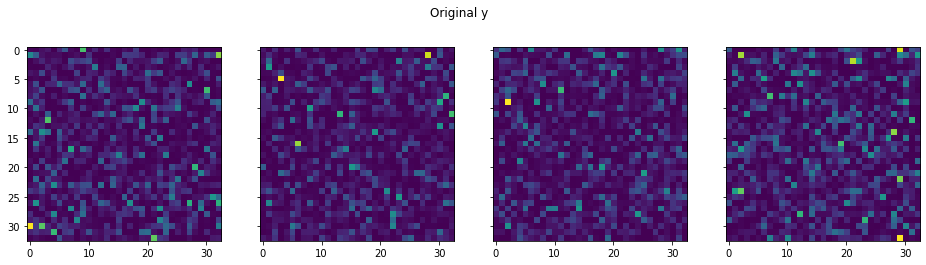

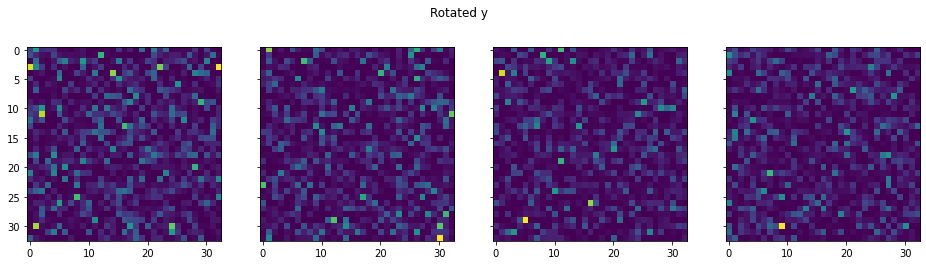

In [ ]:
#@title Check

# Initialize a tensor
y = torch.randn(1, 1, 4, 33, 33)**2

# p4 Rotation with r=1
ry = rotate_p4(y, 1)


# Plots of y
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, squeeze=True, figsize=(16, 4))
for i in range(4):
  axes[i].imshow(y[0, 0, i].numpy())
fig.suptitle('Original y')
plt.show()

# Plots of ry
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, squeeze=True, figsize=(16, 4))
for i in range(4):
  axes[i].imshow(ry[0, 0, i].numpy())
fig.suptitle('Rotated y')
plt.show()




### Group Action on the space of functions over $p4$ 

So, $p4$ is the *Wallpaper group*, i.e. the group of translations and rotations by multiples of $\frac{\pi}{2}$ of a grid. Its general element is identified by a tuple $(h, w, r)$, where 
* $h, w \in \mathbb{Z}$ are integer translations
* $r \in C_4$ is a rotation.

To reduce the notation, we write $(\mathbf{t}, r)$ with $\mathbf{t} = (h, w)$, instead of $(h, w, r)$.

The element $(\mathbf{t}, r)$ acts on a point $\mathbf{p} \in \mathbb{Z}^2$ on the grid by first rotating the point with $r \in C_4$ and then translating it with $\mathbf{t}$, i.e. $(\mathbf{t}, r).\mathbf{p} = \mathbf{t} + r.\mathbf{p}$.


Some proprieties are: 
1. Composition of two elements $(\mathbf{t}, r)$ and $(\mathbf{p}, s)$ is $(\mathbf{t}, r) \cdot (\mathbf{p}, s) = (\mathbf{t} + r.\mathbf{p}, r\cdot s)$.
2. The inverse of $(\mathbf{t}, r)$ is defined as $(\mathbf{t}, r)^{-1} = (r^{-1}.-\mathbf{t}, r^{-1})$.


---

# Equivariant Convolutional Networks
To define equivariant convolutional networks, we start introducing the concepts with this order:
* Lifting convolution;
* Group convolution;
* Deep convolutional net.

###  Implement Lifting Convolution 

To explain a **lifting convolution** in simple terms, we can imagine a transformation that maps the input signal $X$ to a larger feature domain $Y$.


The function $y \in Y$ can be implemented as a $4$-channels image , where the $i$-th channel is defined as $y_i(\mathbf{t}) = y(\mathbf{t}, r=i) \in \mathbb{R}$ $ ∀i=0,…,3$. Therefore, $Y$ is the space of all functions $y: p4 \to \mathbb{R}$, i.e. is a $G$-space with a natural action of $p4$ on it:

$$
  [(\mathbf{t}, r).y](\mathbf{p}, s) := y((\mathbf{t}, r)^{-1} \cdot (\mathbf{p}, s)) = y(r^{-1}(\mathbf{p} - \mathbf{t}), r^{-1}s)
$$

Where it is possible notice the definition of *natural action*:
a group $G$ has a natural action on the functions over its elements; if $x: G \to \mathbb{R}$ and $g \in G$, the function $g.x$ is defined as:
$$
  [g.x](h) := x(g^{-1} \cdot h) 
$$
where $g, h \in G$. 


The inverse of group elements $(\mathbf{t}, r)^{-1} = (r^{-1}.-\mathbf{t}, r^{-1})$, represents a ounterclockwise rotation and a traslation  in which the result is $(r^{-1}.-\mathbf{t}, r^{-1})(\mathbf{p}, s) = (\mathbf{t}, r) \cdot (\mathbf{p}, s) = (-\mathbf{t} + r^{-1}.\mathbf{p}, r^{-1}\cdot s)$. Then the third step demonstrate that the rotation affectes both rotation and traslation.


After constructing the filter, it is checked using the following mathematical expression taken from [here](http://proceedings.mlr.press/v48/cohenc16.pdf): *a representation space can obtain its structure from other
representation spaces to which it is connected. For this to
work, the network or layer Φ that maps one representation
to another should be structure preserving. For G-spaces
this means that Φ has to be equivariant:* 
$$Φ(T_g x) = T'_g Φ(x)$$




This layer can be implemented using the `torch.conv2d` and considering $4$ copies for each learnable filter. Specifically, given an input image and $4$ rotated copies of the filter, the image is convolved independently with each copy, generating four independent outputs that are stacked together to form a single filter to be used in `torch.conv2d`.






In [ ]:
#@title Lifting Convolution Class

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
import matplotlib
%matplotlib inline
from math import sqrt

    


class LiftingConv2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, bias: bool = True):
    
    super(LiftingConv2d, self).__init__()
   
    self.out_channels = out_channels
    self.in_channels = in_channels
    self.kernel_size = kernel_size
    self.padding = padding
    self.stride = 1
    self.dilation = 1
 

    #  Initialization of Parameters 
    self.weight = None
    self.weight = torch.nn.Parameter(torch.zeros(out_channels, in_channels, kernel_size, kernel_size), requires_grad=True)
    self.weight.data.normal_(0, 1. / np.sqrt(out_channels * in_channels))



    # Initialization of Bias
    self.bias = None
    if bias:
      self.bias = torch.nn.Parameter(torch.zeros(self.out_channels), requires_grad=True).data.normal_(0, 1./np.sqrt(self.out_channels))  
    



  
  def build_filter(self) ->torch.Tensor:

    _filter = None
    _bias = None
  
    # Define filter
    _filter = torch.stack([rotate(self.weight,i) for i in range(4)],dim=1).to(self.weight.device)

   # Define Bias
    if self.bias is not None:
      _bias = torch.stack([self.bias for _ in range(4)], dim=1).to(self.weight.device)    
    else:
      _bias = None


    return _filter, _bias






  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()

    assert _bias.shape == (self.out_channels, 4)
    assert _filter.shape == (self.out_channels, 4, self.in_channels, self.kernel_size, self.kernel_size)

    # to be able to use torch.conv2d, we need to reshape the filter and bias to stack together all filters
    _filter = _filter.reshape(self.out_channels * 4, self.in_channels, self.kernel_size, self.kernel_size)
    _bias = _bias.reshape(self.out_channels * 4)

    out = torch.conv2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)
    
    # `out` has now shape `batch_size x out_channels*4 x W x H`
    # we need to reshape it to `batch_size x out_channels x 4 x W x H` to have the shape we expect

    return out.view(-1, self.out_channels, 4, out.shape[-2], out.shape[-1])



In [ ]:
# @title Check Lifting convolution
# Check taken from Notebook of Gabriele Cesa
# Let's check if the layer is really equivariant


in_channels = 5
out_channels = 10
kernel_size = 3
batchsize = 6
S = 33

layer = LiftingConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size = kernel_size, padding=1, bias=True)
layer.eval()


x = torch.randn(batchsize, in_channels, S, S)
print("Size of x ", x.size())

# the input image belongs to the space X, so we use the original action to rotate it
gx = rotate(x, 1)
print("Size of gx ",gx.size())

# compute the output
psi_x = layer(x)
psi_gx = layer(gx)

print("psi_x size: ",psi_x.size())
print("psi_gx size:", psi_gx.size())


# the output is a function in the space Y, so we need to use the new action to rotate it
g_psi_x = rotate_p4(psi_x, 1)

assert psi_x.shape == g_psi_x.shape
assert psi_x.shape == (batchsize, out_channels, 4, S, S)

# check the model is giving meaningful outputs
assert not torch.allclose(psi_x, torch.zeros_like(psi_x), atol=1e-4, rtol=1e-4)

# check equivariance
assert torch.allclose(psi_gx, g_psi_x, atol=1e-6, rtol=1e-6)

# check the model has the right number of parameters
assert layer.weight.numel() == in_channels * out_channels * kernel_size**2
assert layer.bias.numel() == out_channels

Size of x  torch.Size([6, 5, 33, 33])
Size of gx  torch.Size([6, 5, 33, 33])
psi_x size:  torch.Size([6, 10, 4, 33, 33])
psi_gx size: torch.Size([6, 10, 4, 33, 33])



Problem : the output space $Y$ is different from its input space $X$, it's not possibile directly feed the output of the lifting layer into another lifting layer to build a deep architecture.

### **Group Convolution**
The limitations of the lifting layer can be addressed by using the group convolution layer. Given a filter $\psi \in X$ and an input image $x \in X$, the group convolution $\psi \star x$ can be defined as:

$$
  [\psi \star x](\mathbf{t}, r) := \sum_{\mathbf{p} \in \mathbb{Z}^2} \psi((\mathbf{t}, r)^{-1} \mathbf{p})\ x(\mathbf{p})
                                 = \sum_{\mathbf{p} \in \mathbb{Z}^2} \psi(r^{-1} (\mathbf{p} - \mathbf{t}))\ x(\mathbf{p})
$$

Note that both the filter and the image belong to $X$, so we can adapt the equation to inputs that are functions of elements of a group, i.e., functions of $Y$. By recalling the definition of natural action, we can define a filter in the space $Y$ instead of $X$. Considering that $x$ and $\psi \in Y$, we have:


$$
  [\psi \star x](g) := \sum_{h \in H} \psi(g^{-1} \cdot h)\ x(h)
$$

Here, $g \in G$, and $H$ is a subgroup of $G$. The output still belongs to $Y$, the space of functions on the group $G$. Therefore, it is possible to build deep models since the output of a layer can be used as input for another layer.

We can apply this to the case under examination, i.e., for $G=C_4$, rewriting:


$$
  [\psi \star x](\mathbf{t}, r) := \sum_{s \in C_4} \sum_{\mathbf{p} \in \mathbb{Z}^2} \psi((\mathbf{t}, r)^{-1} (\mathbf{p}, s))\ x(\mathbf{p}, s) = \sum_{s \in C_4} \sum_{\mathbf{p} \in \mathbb{Z}^2} [r.\psi](\mathbf{p} - \mathbf{t}, s)\ x(\mathbf{p}, s)
$$
where $\psi((\mathbf{t}, r)^{-1} (\mathbf{p}, s)) = \psi(r^{-1} (\mathbf{p} - \mathbf{t}, s)) = [r.\psi](\mathbf{p} - \mathbf{t}, s)$.
The last part of the equation, we also recognize the classic definition of [discrete convolution](https://en.wikipedia.org/wiki/Convolution#Discrete_convolution), i.e., `torch.conv2d`.



Let's start with the output of a lifting layer as the starting point. It will be composed of a channel for each channel rotation $s$. There will also be a channel for rotations, so we will have a total of $4\times4$ convolutions. The filter will therefore be formed by four channels, one for each rotation. For each copy of the filter, we consider both pixel rotation and cyclic permutation of the four channels.

The equivariance check described earlier still holds.



In [ ]:
# @title GroupConv2D
class GroupConv2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, bias: bool = True):
    
    super(GroupConv2d, self).__init__()

    self.kernel_size = kernel_size
    self.stride = 1
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels
    
    # Inizializziamo e definiamo il tensore dei parametri
    self.weight = None
    self.weight = torch.nn.Parameter(torch.zeros(out_channels, in_channels,4, kernel_size, kernel_size), requires_grad=True)
    self.weight.data.normal_(0, (1. / np.sqrt(out_channels * in_channels)))
  
    # Inizializziamo e definiamo il tensore del bias
    self.bias = None
    if bias:
      self.bias = torch.nn.Parameter(torch.zeros(self.out_channels)/np.sqrt(self.out_channels), requires_grad=True)  #.cuda()

  
  def build_filter(self) ->torch.Tensor:

    
    _filter = None
    _bias = None
   
   # Filtro
    _filter=torch.stack([rotate_p4(self.weight,r) for r in range(4)],dim=1).to(self.weight.device)

   # Bias
    if self.bias is not None:
      _bias = torch.stack([self.bias for _ in range(4)], dim=1).to(self.bias.device)
    else:
      _bias = None


    return _filter, _bias


    

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()

    assert _bias.shape == (self.out_channels, 4)
    assert _filter.shape == (self.out_channels, 4, self.in_channels, 4, self.kernel_size, self.kernel_size)

    # to be able to use torch.conv2d, we need to reshape the filter and bias to stack together all filters
    _filter = _filter.reshape(self.out_channels * 4, self.in_channels * 4, self.kernel_size, self.kernel_size)
    _bias = _bias.reshape(self.out_channels * 4)

    # this time, also the input has shape `batch_size x in_channels x 4 x W x H`
    # so we need to reshape it to `batch_size x in_channels*4 x W x H` to be able to use torch.conv2d
    x = x.view(x.shape[0], self.in_channels*4, x.shape[-2], x.shape[-1])

    out = torch.conv2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)
    
    # `out` has now shape `batch_size x out_channels*4 x W x H`
    # we need to reshape it to `batch_size x out_channels x 4 x W x H` to have the shape we expect

    return out.view(-1, self.out_channels, 4, out.shape[-2], out.shape[-1])



In [ ]:
#@title Check Group Conv2d
# Check taken from Gabriele Cesa notebook
# Let's check if the layer is really equivariant

in_channels = 2
out_channels = 5
kernel_size = 3
batchsize = 4
S = 33

#layer input 5,10,3
layer = GroupConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size = kernel_size, padding=1, bias=True)
layer.eval()

x = torch.randn(batchsize, in_channels, 4, S, S)**2
# the input image belongs to the space Y, so this time we use the new action to rotate it
gx = rotate_p4(x, 1)
print("size of x and gx " ,x.size(),gx.size())


print(x.shape)
# compute the output
psi_x = layer(x)
print(psi_x.shape)
psi_gx = layer(gx)
print(gx.shape, psi_gx.shape)

# the output is a function in the space Y, so we need to use the new action to rotate it
g_psi_x = rotate_p4(psi_x, 1)

assert psi_x.shape == g_psi_x.shape
assert psi_x.shape == (batchsize, out_channels, 4, S, S)

# check the model is giving meaningful outputs
assert not torch.allclose(psi_x, torch.zeros_like(psi_x), atol=1e-4, rtol=1e-4)

# check equivariance
assert torch.allclose(psi_gx, g_psi_x, atol=1e-5, rtol=1e-5)

# check the model has the right number of parameters
assert layer.weight.numel() == in_channels * out_channels * 4* kernel_size**2
assert layer.bias.numel() == out_channels

size of x and gx  torch.Size([4, 2, 4, 33, 33]) torch.Size([4, 2, 4, 33, 33])
torch.Size([4, 2, 4, 33, 33])
torch.Size([4, 5, 4, 33, 33])
torch.Size([4, 2, 4, 33, 33]) torch.Size([4, 5, 4, 33, 33])


## Equivariant Networks - Implement the convolutionals class


An equivariant neural network starts with a *lifting layer* to map an input image $x \in X$ into a function $y \in Y$ over the group $p4$.
We can now alternate a sequence of non-linearities (e.g. ReLU) and *group-convolutions*, which map $Y$ to $Y$.

Since we will apply this network to the task of image classification, in the last layer we apply a *pooling* operation as is normally done in a CNN; this time, however, we also pool over the $4$ rotational channels.


###  Implement A Deep Rotation Equivariant CNN 

All convolutions are followed by `torch.nn.MaxPool3d` and `torch.nn.ReLU`.
Note that we use `MaxPool3d` since our feature tensors have $5$ dimensions (there is an additional dimension of size $4$). All hyperparameters, padding and stride are taken from [(T.Cohen, 2016)](https://arxiv.org/abs/1602.07576).


In [ ]:
#@title Vanilla CNN


class CNN(torch.nn.Module):

  def __init__(self, input_channels=1, n_classes=10)->None:

    super(CNN, self).__init__()
    self.kernel_size = 3
    self.stride = 2
    self.padding = 1       
    channels=[16,32,64,128,256] 

    self.layer1 = nn.Sequential(
        nn.Conv2d(input_channels, channels[0], kernel_size = 3, bias=True), 
        torch.nn.ReLU(),
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d( channels[0] , channels[1], kernel_size = 3, bias = True), 
        torch.nn.ReLU(),
    )


    self.layer3 = nn.Sequential(
        nn.Conv2d( channels[1], channels[2], kernel_size = 3, bias = True), 
        nn.MaxPool2d(kernel_size = 2),
        torch.nn.ReLU(),

        
    )

    self.layer4 = nn.Sequential(
        nn.Conv2d( channels[2], channels[3], kernel_size = 3, bias = True),
        nn.MaxPool2d(kernel_size = 2),
        torch.nn.ReLU(),
    )

    self.layer5 = nn.Sequential(
        nn.Conv2d( channels[3], channels[4], kernel_size = 3, bias = True),
        nn.MaxPool2d(kernel_size = 2),
        torch.nn.ReLU(),
    )

    self.fc1 = nn.Linear(channels[4], n_classes)  
    self.fc2 = nn.Linear(n_classes, n_classes)



  def forward(self,input: torch.Tensor)->torch.Tensor:

     x = self.layer1(input)
     x = self.layer2(x) 
     x = self.layer3(x)
     x = self.layer4(x)
     x = self.layer5(x) 
     x = x.view(x.shape[0], -1)
     x = self.fc1(x)
     result = self.fc2(x)
 
     return result





# Let's try CNN model 

net = CNN()

x = torch.randn(5, 1, 33, 33)

y = net(x)

assert y.shape == (5, 10)

# Let's check if the model is invariant!

gx = rotate(x, 1)

gy = net(gx)

assert torch.allclose(y, gy, atol=1e-2, rtol=1e-2)

# Number of parameters
sum(x.numel() for x in net.parameters() if x.requires_grad)

395000

In [ ]:
#@title Simil Z2CNN 
class Z2CNN(torch.nn.Module):

  def __init__(self, input_channels=1, n_classes=10)->None:

    super(Z2CNN, self).__init__()
    self.kernel_size = 3
    self.stride = 2
    self.padding = 1
    channels=[16,32,64,128,256]
    
    self.layer1 = nn.Sequential(
        nn.Conv2d(input_channels, channels[0], kernel_size = 3, bias=True), 
        torch.nn.ReLU(),
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d( channels[0] , channels[1], kernel_size = 3, bias = True), 
        torch.nn.ReLU(),
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d( channels[1], channels[2], kernel_size = 3, bias = True), 
        torch.nn.BatchNorm2d(channels[2]),
        nn.MaxPool2d(kernel_size = 2),
        torch.nn.Dropout(p=0.3),
        torch.nn.ReLU(),
    )

    self.layer4 = nn.Sequential(
        nn.Conv2d( channels[2], channels[3], kernel_size = 3, bias = True),
        torch.nn.BatchNorm2d(channels[3]),
        nn.MaxPool2d(kernel_size = 2),
        torch.nn.Dropout(p=0.3),
        torch.nn.ReLU(),
    )

    self.layer5 = nn.Sequential(
        nn.Conv2d( channels[3], channels[4], kernel_size = 3, bias = True),
        torch.nn.BatchNorm2d(channels[4]),
        nn.MaxPool2d(kernel_size = 2),
        torch.nn.Dropout(p=0.3),
        torch.nn.ReLU(),
    )

    self.fc1 = nn.Linear(channels[4], n_classes) 
    self.fc2 = nn.Linear(n_classes, n_classes)


  def forward(self,input: torch.Tensor)->torch.Tensor:

     x = self.layer1(input)
     x = self.layer2(x) 
     x = self.layer3(x)
     x = self.layer4(x)
     x = self.layer5(x)
     x = x.view(x.shape[0], -1)
     x = self.fc1(x)
     x = self.fc2(x)
     
     return x







# Let's try our model Z2CNN

net = Z2CNN()

x = torch.randn(5, 1, 33, 33)

y = net(x)

assert y.shape == (5, 10)

# Let's check if the model is invariant!

gx = rotate(x, 1)

gy = net(gx)

#assert torch.allclose(y, gy, atol=1e-1, rtol=1e-1)

# Number of parameters
sum(x.numel() for x in net.parameters() if x.requires_grad)

395896

In [ ]:
# @title P4CNN 

class P4CNN(torch.nn.Module):
  def __init__(self, n_classes=10):

    super(P4CNN, self).__init__()

    self.kernel_size = (1,3,3)
    self.stride = (1,2,2)
    self.padding = (0,1,1)
    channels = [8, 16, 32, 64, 128]




    self.layer1 = nn.Sequential(
        LiftingConv2d(in_channels = 1, out_channels = channels[0], kernel_size = 3,padding =1, bias=True), # output: 5,8,4,33,33
        torch.nn.MaxPool3d(self.kernel_size, self.stride, self.padding), #5,8,4,17,17
        torch.nn.ReLU(),
    )


    self.layer2 = nn.Sequential(
        GroupConv2d(channels[0], channels[1], kernel_size = 3, padding = 1, bias=True), # 5,16,4,17,17
        torch.nn.MaxPool3d(self.kernel_size, self.stride, self.padding), # 5,16,4,9,9
        torch.nn.ReLU(),
    )

 
    self.layer3 = nn.Sequential(
        GroupConv2d(channels[1], channels[2], kernel_size = 3, padding = 1, bias=True), # 5,32,4,9,9
        torch.nn.MaxPool3d(self.kernel_size, self.stride, self.padding), #5,32,4,5,5
        torch.nn.ReLU(),
    )


    self.layer4 = nn.Sequential(
        GroupConv2d(channels[2], channels[3], kernel_size = 3, padding = 1, bias=True), # 5,64,4,5,5
        torch.nn.MaxPool3d(self.kernel_size, self.stride, self.padding), # 5,64,4,3,3
        torch.nn.ReLU(),
    )



    self.layer5 = nn.Sequential(
        GroupConv2d(channels[3], channels[4], kernel_size = 3, padding = 1, bias=True), # 5,128,4,3,3
        torch.nn.MaxPool3d(kernel_size = (4,3,3), stride=(1,1,1), padding = (0,0,0)), #5,128,1, 1,1
        torch.nn.ReLU(),
    )

    self.fc1 = nn.Linear(channels[4], n_classes) #Channels[4]*1*1 
    self.fc2 = nn.Linear(n_classes, n_classes)


  def forward(self, input: torch.Tensor):
    
    
   
     
    x = self.layer1(input)
    x = self.layer2(x) 
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)  
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    result = self.fc2(x)

    return result

 








# Let's try our model P4CNN

net = P4CNN()

x = torch.randn(5, 1, 33, 33)

y = net(x)

assert y.shape == (5, 10)

# Let's check if the model is invariant!

gx = rotate(x, 1)

gy = net(gx)

assert torch.allclose(y, gy, atol=1e-5, rtol=1e-5)

# Number of parameters
sum(x.numel() for x in net.parameters() if x.requires_grad)

393392

In [ ]:
# @title P4CNNWithBatchNorm 

class P4CNNWithBatchNorm(torch.nn.Module):
  def __init__(self, n_classes=10):

    super(P4CNNWithBatchNorm, self).__init__()

    self.kernel_size = (1,3,3)
    self.stride = (1,2,2)
    self.padding = (0,1,1)

    channels = [8, 16, 32, 64, 128] 


    self.layer1 = nn.Sequential(
        LiftingConv2d(in_channels = 1, out_channels = channels[0], kernel_size = 3,padding =1, bias=True), 
        torch.nn.BatchNorm3d(channels[0]),
        torch.nn.MaxPool3d(self.kernel_size, self.stride, self.padding), 
        torch.nn.ReLU(),
    )


    self.layer2 = nn.Sequential(
        GroupConv2d(channels[0], channels[1], kernel_size = 3, padding = 1, bias=True), 
        torch.nn.BatchNorm3d(channels[1]),
        torch.nn.MaxPool3d(self.kernel_size, self.stride, self.padding), 
        torch.nn.ReLU(),
    )

 
    self.layer3 = nn.Sequential(
        GroupConv2d(channels[1], channels[2], kernel_size = 3, padding = 1, bias=True), 
        torch.nn.BatchNorm3d(channels[2]),
        torch.nn.MaxPool3d(self.kernel_size, self.stride, self.padding), 
        torch.nn.ReLU(),
    )


    self.layer4 = nn.Sequential(
        GroupConv2d(channels[2], channels[3], kernel_size = 3, padding = 1, bias=True), 
        torch.nn.BatchNorm3d(channels[3]),
        torch.nn.MaxPool3d(self.kernel_size, self.stride, self.padding), 
        torch.nn.ReLU(),
    )



    self.layer5 = nn.Sequential(
        GroupConv2d(channels[3], channels[4], kernel_size = 3, padding = 1, bias=True), 
        torch.nn.BatchNorm3d(channels[4]),
        torch.nn.MaxPool3d(kernel_size = (4,3,3), stride=(1,1,1), padding = (0,0,0)), 
        torch.nn.ReLU(),
    )

    self.fc1 = nn.Linear(channels[4], n_classes) 
    self.fc2 = nn.Linear(n_classes, n_classes)


  def forward(self, input: torch.Tensor):
    
    
   
     
    x = self.layer1(input)
    x = self.layer2(x) 
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)  
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    result = self.fc2(x)

    return result

    








# Let's try our model P4CNN

net = P4CNNWithBatchNorm()

x = torch.randn(5, 1, 33, 33)

y = net(x)

assert y.shape == (5, 10)

# Let's check if the model is invariant!

gx = rotate(x, 1)

gy = net(gx)

assert torch.allclose(y, gy, atol=1e-5, rtol=1e-5)

# Number of parameters
sum(x.numel() for x in net.parameters() if x.requires_grad)

393888

## Rotated Mnist


Let's try now to train out model. We will train the network on rotated MNIST.

First of all, we need to download the dataset; then, we will provide a dataloader for the dataset and a training script.

In [ ]:
# download the dataset
!wget -nc http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip
# uncompress the zip file
!unzip -n mnist_rotation_new.zip -d mnist_rotation_new

--2023-03-21 00:57:10--  http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58424278 (56M) [application/zip]
Saving to: ‘mnist_rotation_new.zip’

mnist_rotation_new. 100%[===================>]  55.72M  11.8MB/s    in 6.2s    

2023-03-21 00:57:17 (9.05 MB/s) - ‘mnist_rotation_new.zip’ saved [58424278/58424278]

Archive:  mnist_rotation_new.zip
  inflating: mnist_rotation_new/mnist_all_rotation_normalized_float_train_valid.amat  
  inflating: mnist_rotation_new/mnist_all_rotation_normalized_float_test.amat  


In [ ]:
# @title MnistRotDataset 
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import tqdm

from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'


class MnistRotDataset(Dataset):
    
    def __init__(self, mode, transform=None):
        assert mode in ['train', 'test']
            
        if mode == "train":
            file = "mnist_rotation_new/mnist_all_rotation_normalized_float_train_valid.amat"
        else:
            file = "mnist_rotation_new/mnist_all_rotation_normalized_float_test.amat"
        
        self.transform = transform

        data = np.loadtxt(file, delimiter=' ')
        
        self.labels = data[:, -1].astype(np.int64)
        self.num_samples = len(self.labels)    
        self.images = data[:, :-1].reshape(-1, 28, 28).astype(np.float32)

        # images in MNIST are only 28x28
        # we pad them to have shape 33 x 33
        self.images = np.pad(self.images, pad_width=((0,0), (2, 3), (2, 3)), mode='edge')

        assert self.images.shape == (self.labels.shape[0], 33, 33)
    
    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]
        image = Image.fromarray(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.labels)



mnist_train = MnistRotDataset('train', ToTensor())
mnist_test = MnistRotDataset('test', ToTensor())

# Check lenghts 
# The split is the same of the reference (T.Cohen, 2016)
print("Len Train: ", len(mnist_train))
print("Len Test: ", len(mnist_test))

Len Train:  12000
Len Test:  50000


In [ ]:
#@title Train and Test Class for MNIST
from tqdm.autonotebook import trange, tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def test_MNIST(model: torch.nn.Module):

    # test over the full test set  
    test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64)
    total = 0
    correct = 0


    with torch.no_grad():  
        # Setting
        model.eval()

        for i, (x, t) in enumerate(tqdm(test_loader, desc="Train")):
            x = x.to(device)
            t = t.to(device)

            y = model(x)

            _, prediction = torch.max(y.data, 1)
            total += t.shape[0]
            correct += (prediction == t).sum().item()
    
            
    return correct/total*100.



def train_MNIST(model: torch.nn.Module):


  # train and valid test
 
  train_set, valid_set= train_test_split(mnist_train, test_size =0.1, shuffle = True)    # splitting train-test 80-20
  
  print("Size of training dataset: ", len(train_set),"\n",
      "\nSize of validation dataset: ", len(valid_set))

  # Optimizer and Loss 
  loss_function = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

  # Definition of train loader and valid loader
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=2, shuffle = True)
  valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, num_workers=2, shuffle = True)




  # Model setting
  model.to(device)
  model.train() 


  # Variables inizialitian for statistic
  running_loss = 0.0
  valid_loss = 0.
  min_loss = np.inf

    
  # Loop for training and validation
  for epoch in tqdm(range(30)):

    
    # Train
    for i, (x, t) in enumerate(tqdm(train_loader, desc="Train")):
        
        # Restart gradient
        optimizer.zero_grad()
        

        # Target and input evaluation
        x = x.to(device)
        t = t.to(device)


        # Output evaluation
        y = model(x)


        # Evaluation loss 
        loss = loss_function(y, t)


        # Backpropagation
        loss.backward()


        # Step of optimizer (dL/dTheta, requires_grad=TRUE)
        optimizer.step()


        # Loss increment 
        running_loss += loss.item()

    # Print statistic
    train_loss = running_loss/len(train_set)
    print(f"epoch {epoch} | train loss: {train_loss: .3f}")
    running_loss = 0.0



    # Validation


    # Variable definition 
    correct = 0 
    total = 0
    running_loss_1 = 0.0

    # Loop 
    with torch.no_grad():

      # Setting 
      model.eval()
     
      for i, (x,t) in enumerate(valid_loader):#, position=0, leave=True, desc="Eval"):

          # Target and input evaluation
          x = x.to(device)
          t = t.to(device)

          # Output evaluation
          y = model(x)

          # Loss evaluation
          loss_1 = loss_function(y, t)

          # Statistic
          _, predicted = torch.max(y.data , 1)
          total += t.size(0)
          correct += (predicted == t).sum().item()

          running_loss_1 += loss_1.item()

      # Check decrease of loss
      if running_loss_1 <= min_loss:
        print(f"validation loss descreased to {running_loss_1: .3f}")
        torch.save(model.state_dict(), 'model_MNIST.pt' )
        min_loss = running_loss_1



    accuracy = correct/total*100
    val_loss = running_loss_1/len(valid_set)
    print(f"epoch {epoch} | validation accuracy: {accuracy: .3f} |  validation loss: {val_loss: .3f}") 
    running_loss_1 = 0.0

  
    
  return model


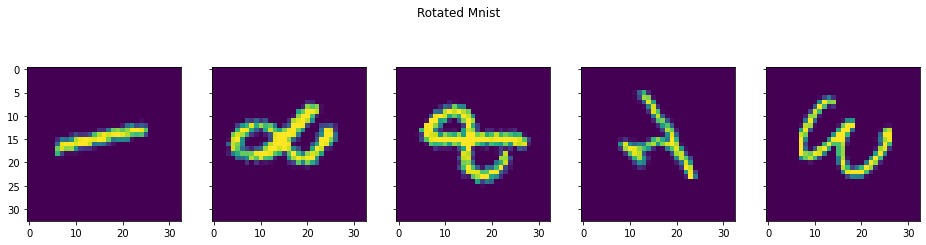

In [ ]:
#@title Plot some images

fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, squeeze=True, figsize=(16, 4))
for i in range(5):
  j=torch.randint(low=0,high=mnist_train.__len__(),size=(1,)) 
  axes[i].imshow(mnist_train.__getitem__(j)[0][0].numpy())


fig.suptitle('Rotated Mnist')
plt.show()

### Train and Test model

In [ ]:
#@title Train and Test Vanilla CNN
model_2 = CNN()

model_2 = train_MNIST(model_2)

acc = test_MNIST(model_2)

print(f'Test accuracy: {acc : .3f}')


Size of training dataset:  10800 
 
Size of validation dataset:  1200


  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 0 | train loss:  0.035
validation loss descreased to  39.190
epoch 0 | validation accuracy:  25.167 |  validation loss:  0.033


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 1 | train loss:  0.028
validation loss descreased to  29.333
epoch 1 | validation accuracy:  48.500 |  validation loss:  0.024


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 2 | train loss:  0.023
validation loss descreased to  25.739
epoch 2 | validation accuracy:  54.000 |  validation loss:  0.021


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 3 | train loss:  0.020
validation loss descreased to  22.616
epoch 3 | validation accuracy:  63.083 |  validation loss:  0.019


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 4 | train loss:  0.018
validation loss descreased to  20.742
epoch 4 | validation accuracy:  66.250 |  validation loss:  0.017


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 5 | train loss:  0.016
epoch 5 | validation accuracy:  65.833 |  validation loss:  0.018


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 6 | train loss:  0.015
validation loss descreased to  17.773
epoch 6 | validation accuracy:  72.667 |  validation loss:  0.015


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 7 | train loss:  0.014
validation loss descreased to  17.117
epoch 7 | validation accuracy:  72.083 |  validation loss:  0.014


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 8 | train loss:  0.013
validation loss descreased to  16.363
epoch 8 | validation accuracy:  74.000 |  validation loss:  0.014


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 9 | train loss:  0.012
validation loss descreased to  15.776
epoch 9 | validation accuracy:  74.833 |  validation loss:  0.013


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 10 | train loss:  0.012
validation loss descreased to  14.531
epoch 10 | validation accuracy:  77.167 |  validation loss:  0.012


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 11 | train loss:  0.011
validation loss descreased to  14.517
epoch 11 | validation accuracy:  76.833 |  validation loss:  0.012


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 12 | train loss:  0.010
validation loss descreased to  14.216
epoch 12 | validation accuracy:  78.000 |  validation loss:  0.012


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 13 | train loss:  0.010
validation loss descreased to  12.973
epoch 13 | validation accuracy:  79.500 |  validation loss:  0.011


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 14 | train loss:  0.009
validation loss descreased to  12.537
epoch 14 | validation accuracy:  80.917 |  validation loss:  0.010


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 15 | train loss:  0.009
epoch 15 | validation accuracy:  79.833 |  validation loss:  0.011


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 16 | train loss:  0.009
validation loss descreased to  11.643
epoch 16 | validation accuracy:  81.750 |  validation loss:  0.010


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 17 | train loss:  0.008
epoch 17 | validation accuracy:  81.083 |  validation loss:  0.010


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 18 | train loss:  0.008
epoch 18 | validation accuracy:  81.667 |  validation loss:  0.010


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 19 | train loss:  0.008
validation loss descreased to  11.251
epoch 19 | validation accuracy:  82.250 |  validation loss:  0.009


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 20 | train loss:  0.007
epoch 20 | validation accuracy:  80.833 |  validation loss:  0.010


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 21 | train loss:  0.007
validation loss descreased to  11.107
epoch 21 | validation accuracy:  83.250 |  validation loss:  0.009


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 22 | train loss:  0.007
validation loss descreased to  10.735
epoch 22 | validation accuracy:  83.083 |  validation loss:  0.009


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 23 | train loss:  0.006
epoch 23 | validation accuracy:  82.167 |  validation loss:  0.009


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 24 | train loss:  0.006
epoch 24 | validation accuracy:  81.667 |  validation loss:  0.009


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 25 | train loss:  0.006
validation loss descreased to  10.694
epoch 25 | validation accuracy:  83.917 |  validation loss:  0.009


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 26 | train loss:  0.006
validation loss descreased to  10.293
epoch 26 | validation accuracy:  83.750 |  validation loss:  0.009


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 27 | train loss:  0.005
validation loss descreased to  9.726
epoch 27 | validation accuracy:  85.083 |  validation loss:  0.008


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 28 | train loss:  0.005
epoch 28 | validation accuracy:  84.833 |  validation loss:  0.008


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 29 | train loss:  0.005
epoch 29 | validation accuracy:  84.333 |  validation loss:  0.009


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test accuracy:  84.142


In [ ]:
#@title Train and Test Simil Z2CNN
model_2 = Z2CNN()

model_2 = train_MNIST(model_2)

acc = test_MNIST(model_2)

print(f'Test accuracy: {acc : .3f}')


Size of training dataset:  10800 
 
Size of validation dataset:  1200


  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 0 | train loss:  0.033
validation loss descreased to  37.593
epoch 0 | validation accuracy:  24.917 |  validation loss:  0.031


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 1 | train loss:  0.025
validation loss descreased to  25.565
epoch 1 | validation accuracy:  55.333 |  validation loss:  0.021


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 2 | train loss:  0.019
validation loss descreased to  20.240
epoch 2 | validation accuracy:  66.250 |  validation loss:  0.017


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 3 | train loss:  0.015
validation loss descreased to  17.537
epoch 3 | validation accuracy:  68.583 |  validation loss:  0.015


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 4 | train loss:  0.012
validation loss descreased to  13.989
epoch 4 | validation accuracy:  77.750 |  validation loss:  0.012


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 5 | train loss:  0.010
validation loss descreased to  12.915
epoch 5 | validation accuracy:  79.750 |  validation loss:  0.011


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 6 | train loss:  0.009
validation loss descreased to  12.641
epoch 6 | validation accuracy:  79.333 |  validation loss:  0.011


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 7 | train loss:  0.008
validation loss descreased to  11.122
epoch 7 | validation accuracy:  82.333 |  validation loss:  0.009


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 8 | train loss:  0.007
validation loss descreased to  10.320
epoch 8 | validation accuracy:  83.417 |  validation loss:  0.009


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 9 | train loss:  0.006
epoch 9 | validation accuracy:  84.250 |  validation loss:  0.009


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 10 | train loss:  0.006
validation loss descreased to  9.376
epoch 10 | validation accuracy:  85.083 |  validation loss:  0.008


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 11 | train loss:  0.005
validation loss descreased to  9.286
epoch 11 | validation accuracy:  85.500 |  validation loss:  0.008


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 12 | train loss:  0.005
validation loss descreased to  9.228
epoch 12 | validation accuracy:  85.417 |  validation loss:  0.008


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 13 | train loss:  0.004
validation loss descreased to  9.037
epoch 13 | validation accuracy:  85.917 |  validation loss:  0.008


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 14 | train loss:  0.004
epoch 14 | validation accuracy:  85.250 |  validation loss:  0.008


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 15 | train loss:  0.004
epoch 15 | validation accuracy:  85.833 |  validation loss:  0.008


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 16 | train loss:  0.004
epoch 16 | validation accuracy:  86.000 |  validation loss:  0.008


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 17 | train loss:  0.003
validation loss descreased to  8.490
epoch 17 | validation accuracy:  87.750 |  validation loss:  0.007


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 18 | train loss:  0.003
validation loss descreased to  8.425
epoch 18 | validation accuracy:  87.583 |  validation loss:  0.007


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 19 | train loss:  0.003
validation loss descreased to  8.154
epoch 19 | validation accuracy:  87.583 |  validation loss:  0.007


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 20 | train loss:  0.002
epoch 20 | validation accuracy:  87.417 |  validation loss:  0.007


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 21 | train loss:  0.002
epoch 21 | validation accuracy:  87.750 |  validation loss:  0.007


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 22 | train loss:  0.002
epoch 22 | validation accuracy:  88.917 |  validation loss:  0.007


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 23 | train loss:  0.002
epoch 23 | validation accuracy:  88.250 |  validation loss:  0.007


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 24 | train loss:  0.002
epoch 24 | validation accuracy:  87.167 |  validation loss:  0.007


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 25 | train loss:  0.002
validation loss descreased to  7.854
epoch 25 | validation accuracy:  88.917 |  validation loss:  0.007


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 26 | train loss:  0.002
epoch 26 | validation accuracy:  88.500 |  validation loss:  0.007


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 27 | train loss:  0.001
epoch 27 | validation accuracy:  88.167 |  validation loss:  0.007


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 28 | train loss:  0.001
epoch 28 | validation accuracy:  87.667 |  validation loss:  0.007


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 29 | train loss:  0.001
epoch 29 | validation accuracy:  88.417 |  validation loss:  0.007


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test accuracy:  88.254


In [ ]:
#@title Train and Test P4CNN
model = P4CNN()

model = train_MNIST(model)

acc = test_MNIST(model)
print(f'Test Accuracy: {acc :.3f}')



Size of training dataset:  10800 
 
Size of validation dataset:  1200


  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 0 | train loss:  0.034
validation loss descreased to  36.188
epoch 0 | validation accuracy:  29.167 |  validation loss:  0.030


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 1 | train loss:  0.027
validation loss descreased to  28.567
epoch 1 | validation accuracy:  55.083 |  validation loss:  0.024


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 2 | train loss:  0.021
validation loss descreased to  23.032
epoch 2 | validation accuracy:  62.750 |  validation loss:  0.019


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 3 | train loss:  0.017
validation loss descreased to  18.997
epoch 3 | validation accuracy:  71.167 |  validation loss:  0.016


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 4 | train loss:  0.014
validation loss descreased to  15.633
epoch 4 | validation accuracy:  77.000 |  validation loss:  0.013


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 5 | train loss:  0.012
validation loss descreased to  13.854
epoch 5 | validation accuracy:  78.083 |  validation loss:  0.012


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 6 | train loss:  0.010
validation loss descreased to  12.194
epoch 6 | validation accuracy:  80.917 |  validation loss:  0.010


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 7 | train loss:  0.009
validation loss descreased to  10.648
epoch 7 | validation accuracy:  84.750 |  validation loss:  0.009


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 8 | train loss:  0.008
validation loss descreased to  10.423
epoch 8 | validation accuracy:  83.583 |  validation loss:  0.009


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 9 | train loss:  0.007
validation loss descreased to  8.558
epoch 9 | validation accuracy:  87.333 |  validation loss:  0.007


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 10 | train loss:  0.007
validation loss descreased to  7.811
epoch 10 | validation accuracy:  88.667 |  validation loss:  0.007


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 11 | train loss:  0.006
validation loss descreased to  7.717
epoch 11 | validation accuracy:  87.833 |  validation loss:  0.006


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 12 | train loss:  0.006
validation loss descreased to  6.868
epoch 12 | validation accuracy:  89.667 |  validation loss:  0.006


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 13 | train loss:  0.006
validation loss descreased to  6.586
epoch 13 | validation accuracy:  89.917 |  validation loss:  0.005


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 14 | train loss:  0.005
epoch 14 | validation accuracy:  89.083 |  validation loss:  0.006


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 15 | train loss:  0.005
validation loss descreased to  6.305
epoch 15 | validation accuracy:  90.083 |  validation loss:  0.005


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 16 | train loss:  0.005
validation loss descreased to  5.881
epoch 16 | validation accuracy:  91.250 |  validation loss:  0.005


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 17 | train loss:  0.004
epoch 17 | validation accuracy:  90.250 |  validation loss:  0.005


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 18 | train loss:  0.004
validation loss descreased to  5.778
epoch 18 | validation accuracy:  90.333 |  validation loss:  0.005


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 19 | train loss:  0.004
validation loss descreased to  5.353
epoch 19 | validation accuracy:  92.083 |  validation loss:  0.004


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 20 | train loss:  0.004
epoch 20 | validation accuracy:  90.083 |  validation loss:  0.005


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 21 | train loss:  0.004
validation loss descreased to  5.136
epoch 21 | validation accuracy:  92.083 |  validation loss:  0.004


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 22 | train loss:  0.004
validation loss descreased to  4.953
epoch 22 | validation accuracy:  92.167 |  validation loss:  0.004


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 23 | train loss:  0.004
epoch 23 | validation accuracy:  91.250 |  validation loss:  0.005


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 24 | train loss:  0.003
validation loss descreased to  4.939
epoch 24 | validation accuracy:  91.750 |  validation loss:  0.004


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 25 | train loss:  0.003
epoch 25 | validation accuracy:  90.583 |  validation loss:  0.005


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 26 | train loss:  0.003
validation loss descreased to  4.707
epoch 26 | validation accuracy:  92.333 |  validation loss:  0.004


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 27 | train loss:  0.003
epoch 27 | validation accuracy:  91.667 |  validation loss:  0.004


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 28 | train loss:  0.003
epoch 28 | validation accuracy:  92.500 |  validation loss:  0.004


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 29 | train loss:  0.003
validation loss descreased to  4.634
epoch 29 | validation accuracy:  92.750 |  validation loss:  0.004


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test Accuracy: 92.356


In [ ]:
#@title Train and Test P4CNNBatch
model = P4CNNWithBatchNorm()

model = train_MNIST(model)

acc = test_MNIST(model)

print(f'Test Accuracy: {acc :.3f}')


Size of training dataset:  10800 
 
Size of validation dataset:  1200


  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 0 | train loss:  0.026
validation loss descreased to  22.010
epoch 0 | validation accuracy:  70.500 |  validation loss:  0.018


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 1 | train loss:  0.012
validation loss descreased to  12.163
epoch 1 | validation accuracy:  81.500 |  validation loss:  0.010


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 2 | train loss:  0.008
validation loss descreased to  9.625
epoch 2 | validation accuracy:  84.417 |  validation loss:  0.008


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 3 | train loss:  0.006
validation loss descreased to  7.515
epoch 3 | validation accuracy:  89.333 |  validation loss:  0.006


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 4 | train loss:  0.005
validation loss descreased to  6.502
epoch 4 | validation accuracy:  90.250 |  validation loss:  0.005


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 5 | train loss:  0.004
validation loss descreased to  5.761
epoch 5 | validation accuracy:  91.167 |  validation loss:  0.005


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 6 | train loss:  0.004
validation loss descreased to  5.251
epoch 6 | validation accuracy:  91.917 |  validation loss:  0.004


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 7 | train loss:  0.003
validation loss descreased to  5.248
epoch 7 | validation accuracy:  92.000 |  validation loss:  0.004


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 8 | train loss:  0.003
validation loss descreased to  4.996
epoch 8 | validation accuracy:  92.250 |  validation loss:  0.004


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 9 | train loss:  0.003
validation loss descreased to  4.228
epoch 9 | validation accuracy:  93.500 |  validation loss:  0.004


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 10 | train loss:  0.002
epoch 10 | validation accuracy:  93.167 |  validation loss:  0.004


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 11 | train loss:  0.002
validation loss descreased to  3.844
epoch 11 | validation accuracy:  94.333 |  validation loss:  0.003


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 12 | train loss:  0.002
epoch 12 | validation accuracy:  93.417 |  validation loss:  0.004


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 13 | train loss:  0.002
validation loss descreased to  3.767
epoch 13 | validation accuracy:  93.000 |  validation loss:  0.003


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 14 | train loss:  0.002
validation loss descreased to  3.713
epoch 14 | validation accuracy:  94.083 |  validation loss:  0.003


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 15 | train loss:  0.002
validation loss descreased to  3.459
epoch 15 | validation accuracy:  94.750 |  validation loss:  0.003


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 16 | train loss:  0.002
epoch 16 | validation accuracy:  94.583 |  validation loss:  0.003


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 17 | train loss:  0.001
validation loss descreased to  3.245
epoch 17 | validation accuracy:  95.000 |  validation loss:  0.003


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 18 | train loss:  0.001
validation loss descreased to  3.138
epoch 18 | validation accuracy:  94.833 |  validation loss:  0.003


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 19 | train loss:  0.001
epoch 19 | validation accuracy:  93.667 |  validation loss:  0.003


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 20 | train loss:  0.001
epoch 20 | validation accuracy:  93.917 |  validation loss:  0.003


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 21 | train loss:  0.001
epoch 21 | validation accuracy:  94.250 |  validation loss:  0.003


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 22 | train loss:  0.001
validation loss descreased to  2.989
epoch 22 | validation accuracy:  95.167 |  validation loss:  0.002


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 23 | train loss:  0.001
epoch 23 | validation accuracy:  94.750 |  validation loss:  0.003


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 24 | train loss:  0.001
validation loss descreased to  2.714
epoch 24 | validation accuracy:  95.667 |  validation loss:  0.002


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 25 | train loss:  0.001
epoch 25 | validation accuracy:  94.750 |  validation loss:  0.002


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 26 | train loss:  0.001
epoch 26 | validation accuracy:  95.083 |  validation loss:  0.003


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 27 | train loss:  0.001
validation loss descreased to  2.690
epoch 27 | validation accuracy:  95.250 |  validation loss:  0.002


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 28 | train loss:  0.000
epoch 28 | validation accuracy:  95.500 |  validation loss:  0.002


Train:   0%|          | 0/169 [00:00<?, ?it/s]

epoch 29 | train loss:  0.000
validation loss descreased to  2.636
epoch 29 | validation accuracy:  95.750 |  validation loss:  0.002


Train:   0%|          | 0/782 [00:00<?, ?it/s]

Test Accuracy: 95.622


##Cifar


The [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60k 32x32 colour images in 10 classes, with 6k images per class. There are 50k training images and 10k test images.

The dataset is divided into training batches and test batch, each with 10k images. The test batch contains exactly 1k randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.
Due to their increased complexity, RGB images, and lack of some internal symmetries, the CIFAR10 dataset represents a greater challenge for the convolutional classes than MNIST; for this reason, we expect CNNs and GCNNs to have roughly comparable performances.




In [ ]:
#@title Cifra dataset
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2023,0.1994,0.2010])]
     )

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2023,0.1994,0.2010])]
    )



cifar_train = torchvision.datasets.CIFAR10(root='./data',
                                         train=True,
                                         download=True,
                                         transform=transform_train)
cifar_test =  torchvision.datasets.CIFAR10(root='./data',
                                       train = False,
                                       download= True,
                                       transform = transform_test)
                                         

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



#Check len
print("Len test:", len(cifar_test))
print("Len train: ", len(cifar_train))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Len test: 10000
Len train:  50000


In [ ]:
#@title Train and Test Class CIFAR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Test
def test_Cifar(model: torch.nn.Module):

    # test over the full test set   
    test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=64)
    total = 0
    correct = 0


    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # Setting
    model.eval()

    with torch.no_grad():

        for i, (x, t) in enumerate(tqdm(test_loader, position=0, leave=True,
                                           colour="red", desc=" Test ")):
            x = x.to(device)
            t = t.to(device)

            y = model(x)

            _, prediction = torch.max(y.data, 1)
            total += t.shape[0]
            correct += (prediction == t).sum().item()

            # collect the correct predictions for each class
            for t, prediction in zip(t,prediction):
                if t == prediction:
                  correct_pred[classes[t]] += 1
                total_pred[classes[t]] += 1
    
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count)/total_pred[classname]
      print(f'\n Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    
            
    return correct/total*100.






def train_Cifar(model: torch.nn.Module):


  # train and valid test
  train_set, valid_set = train_test_split(cifar_train, test_size =0.2, shuffle = True)    # splitting train-test 20-80 

  print("Size of training dataset: ", len(train_set),"\n",
      "\nSize of valid dataset: ", len(valid_set))

  # Optimizer and Loss 
  loss_function = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

  # Definition of train loader and valid loader
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=2, shuffle = True)
  valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, num_workers=2, shuffle = True)




  # Model setting
  model.to(device)
  model.train() 


  # Variables inizialitian for statistic
  running_loss = 0.0
  valid_loss = 0.0
  min_loss = np.inf

    
  # Loop for training and validation
  for epoch in tqdm(range(30)):


    # Train
    for i, (x, t) in enumerate(tqdm(train_loader, desc="Train")):
        
        # Restart gradient
        optimizer.zero_grad()
        

        # Target and input evaluation
        x = x.to(device)
        t = t.to(device)


        # Output evaluation
        y = model(x)


        # Evaluation loss 
        loss = loss_function(y, t)


        # Backpropagation
        loss.backward()


        # Step of optimizer (dL/dTheta, requires_grad=TRUE)
        optimizer.step()


        # Loss increment 
        running_loss += loss.item()


    # Print statistic
    train_loss = running_loss/len(train_set)
    print(f"epoch {epoch} | train loss: {train_loss: .3f}")
    running_loss = 0.0

    # Validation

    # Setting 
    model.eval()

    # Variable definition 
    correct = 0 
    total = 0
    running_loss_1 = 0.0

    # Loop 
    with torch.no_grad():
      for i, (x,t) in enumerate(valid_loader):

          # Target and input evaluation
          x = x.to(device)
          t = t.to(device)

          # Output evaluation
          y = model(x)

          # Loss evaluation
          loss_1 = loss_function(y, t)

          # Statistic
          _, predicted = torch.max(y.data , 1)
          total += t.size(0)
          correct += (predicted == t).sum().item()

          running_loss_1 += loss_1.item()


      # Check decrease of loss
      if running_loss_1 <= min_loss:
        print(f"validation loss descreased to {running_loss_1: .3f}")
        torch.save(model.state_dict(), 'model_Cifar.pt' )
        min_loss = running_loss_1



    accuracy = correct/total*100
    val_loss = running_loss_1/len(valid_set)
    print(f"epoch {epoch} | validation accuracy: {accuracy: .3f} |  validation loss: {val_loss: .3f}") 
    running_loss_1 = 0.0


    
  return model











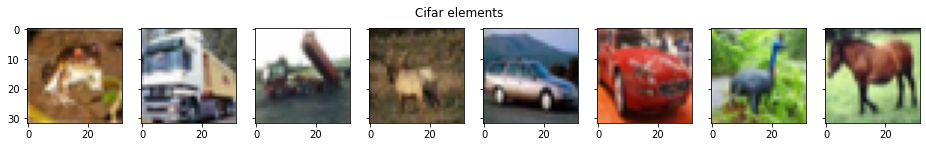

In [ ]:
#@title Plot some images


fig, axes = plt.subplots(1, 8, sharex=True, sharey=True, squeeze=True, figsize=(16, 2))
for i in range(8):
  mean = np.array([0.4914, 0.4822, 0.4465])
  std = np.array([0.2023, 0.1994, 0.2010])
  image, label = cifar_train[i]
  image_example = image.numpy().transpose((1, 2, 0))
  image_example= std * image_example + mean
  image_example= np.clip(image_example, 0, 1) 
  axes[i].imshow(image_example)
fig.suptitle('Cifar elements')
plt.show()

### Class definition


In this section, we will modify the classes that were defined earlier to make them suitable for the CIFAR-10 dataset.

In [ ]:
#@title CifarVanilla CNN


class CifarCNN(torch.nn.Module):

  def __init__(self, input_channels=3, n_classes=10)->None:

    super(CifarCNN, self).__init__()
    self.kernel_size = 3
    self.stride = 2
    self.padding = 1       
    channels=[16,32,64,128,256] 

    self.layer1 = nn.Sequential(
        nn.Conv2d(input_channels, channels[0], kernel_size = 3, bias=True), 
        torch.nn.ReLU(),
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d( channels[0] , channels[1], kernel_size = 3, bias = True), 
        torch.nn.ReLU(),
    )


    self.layer3 = nn.Sequential(
        nn.Conv2d( channels[1], channels[2], kernel_size = 3, bias = True), 
        nn.MaxPool2d(kernel_size = 2),
        torch.nn.ReLU(),

        
    )

    self.layer4 = nn.Sequential(
        nn.Conv2d( channels[2], channels[3], kernel_size = 3, bias = True),
        nn.MaxPool2d(kernel_size = 2),
        torch.nn.ReLU(),
    )



    self.fc1 = nn.Linear(channels[3]*5*5, 32) 
    self.fc2 = nn.Linear(32,16)
    self.fc3 = nn.Linear(16, n_classes) 



  def forward(self,input: torch.Tensor)->torch.Tensor:

     x = self.layer1(input)
     x = self.layer2(x) 
     x = self.layer3(x)
     x = self.layer4(x) 
     x = x.view(x.shape[0], -1)
     x = self.fc1(x)
     x = self.fc2(x)
     x = self.fc3(x)
 
     return x





model=CifarCNN()
print(model)
# Number of parameters
sum(x.numel() for x in model.parameters() if x.requires_grad)

CifarCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (fc1): Linear(in_features=3200, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
)


200570

In [ ]:
#@title Classe CifarZ2CNN
class CifarZ2CNN(torch.nn.Module):

  def __init__(self, input_channels=3, n_classes=10):
    super(CifarZ2CNN, self).__init__()
    self.kernel_size = 3
    self.stride = 2
    self.padding = 1
    channels = [16,32,64,128]


    self.layer1 = nn.Sequential(
        nn.Conv2d(input_channels, channels[0], kernel_size=3, bias=True), 
        torch.nn.ReLU(),
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(channels[0], channels[1], kernel_size=3, bias=True), 
        torch.nn.ReLU(),
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(channels[1], channels[2], kernel_size=3, bias=True), 
        torch.nn.BatchNorm2d(channels[2]),
        nn.MaxPool2d(kernel_size=2),
        torch.nn.Dropout(p=0.3),
        torch.nn.ReLU(),
    )

    self.layer4 = nn.Sequential(
        nn.Conv2d(channels[2], channels[3], kernel_size=3, bias=True),
        torch.nn.BatchNorm2d(channels[3]),
        nn.MaxPool2d(kernel_size=2),
        torch.nn.Dropout(p=0.3),
        torch.nn.ReLU(),
    )

    self.fc1 = nn.Linear(channels[3]*5*5, 32) 
    self.fc2 = nn.Linear(32,16)
    self.fc3 = nn.Linear(16, n_classes)

  def forward(self, input: torch.Tensor) -> torch.Tensor:
    x = self.layer1(input)
    x = self.layer2(x) 
    x = self.layer3(x)
    x = self.layer4(x)
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)

    return x



model=CifarZ2CNN()
print(model)
# Number of parameters
sum(x.numel() for x in model.parameters() if x.requires_grad)

CifarZ2CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): ReLU()
  )
  (fc1): Linear(in_features=3200, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=1

200954

In [ ]:
# @title Class CifarP4CNN 


class CifarP4CNN(torch.nn.Module):
  def __init__(self, n_classes=10)->None:

    super(CifarP4CNN, self).__init__()

    self.kernel_size = (1,2,2)
    self.stride = (1,2,2)
    self.padding = (0,1,1)
    channels = [8, 16, 32, 64] 

   # In this case we start with 3 in_channels
    self.layer1 = nn.Sequential(
        LiftingConv2d(in_channels = 3, out_channels = channels[0], kernel_size = 3,padding =1, bias=True), 
        torch.nn.MaxPool3d(self.kernel_size, self.stride, self.padding), 
        torch.nn.ReLU(),
    )


    self.layer2 = nn.Sequential(
        GroupConv2d(channels[0], channels[1], kernel_size = 3, padding = 1, bias=True),
        torch.nn.MaxPool3d(self.kernel_size, self.stride, self.padding), 
        torch.nn.ReLU(),
    )

 
    self.layer3 = nn.Sequential(
        GroupConv2d(channels[1], channels[2], kernel_size = 3, padding = 1, bias=True),
        torch.nn.MaxPool3d(self.kernel_size, self.stride, self.padding), 
        torch.nn.ReLU(),
    )


    self.layer4 = nn.Sequential(
        GroupConv2d(channels[2], channels[3], kernel_size = 3, padding = 1, bias=True), 
        torch.nn.MaxPool3d(kernel_size = (4,2,2), stride=(1,1,1), padding = (0,0,0)), 
        torch.nn.ReLU(),
    )



    self.fc1 = nn.Linear(channels[3]*4*4, 128) 
    self.fc2 = nn.Linear(128,64) 
    self.fc3 = nn.Linear(64, n_classes) 


  def forward(self, x: torch.Tensor):  

    x = self.layer1(x)
    x = self.layer2(x) 
    x = self.layer3(x)
    x = self.layer4(x)
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = self.fc2(x)
    result = self.fc3(x)

    return result




model=CifarP4CNN()
print(model)
sum(x.numel() for x in model.parameters() if x.requires_grad)


CifarP4CNN(
  (layer1): Sequential(
    (0): LiftingConv2d()
    (1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): GroupConv2d()
    (1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): GroupConv2d()
    (1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): GroupConv2d()
    (1): MaxPool3d(kernel_size=(4, 2, 2), stride=(1, 1, 1), padding=(0, 0, 0), dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


237202

In [ ]:
# @title Class CifarP4CNNWithBatchNorm 

class CifarP4CNNWithBatchNorm(torch.nn.Module):
  def __init__(self, n_classes=10):

    super(CifarP4CNNWithBatchNorm, self).__init__()

    self.kernel_size = (1,2,2)
    self.stride = (1,2,2)
    self.padding = (0,1,1)

    channels = [8, 16, 32, 64] 


    self.layer1 = nn.Sequential(
        LiftingConv2d(in_channels = 3, out_channels = channels[0], kernel_size = 3,padding =1, bias=True), 
        torch.nn.BatchNorm3d(channels[0]),
        torch.nn.MaxPool3d(self.kernel_size, self.stride, self.padding), 
        torch.nn.ReLU(),
    )


    self.layer2 = nn.Sequential(
        GroupConv2d(channels[0], channels[1], kernel_size = 3, padding = 1, bias=True), 
        torch.nn.BatchNorm3d(channels[1]),
        torch.nn.MaxPool3d(self.kernel_size, self.stride, self.padding), 
        torch.nn.ReLU(),
    )

 
    self.layer3 = nn.Sequential(
        GroupConv2d(channels[1], channels[2], kernel_size = 3, padding = 1, bias=True), 
        torch.nn.BatchNorm3d(channels[2]),
        torch.nn.MaxPool3d(self.kernel_size, self.stride, self.padding), 
        torch.nn.ReLU(),
    )


    self.layer4 = nn.Sequential(
        GroupConv2d(channels[2], channels[3], kernel_size = 3, padding = 1, bias=True),
        torch.nn.BatchNorm3d(channels[3]),
        torch.nn.MaxPool3d(kernel_size = (4,2,2), stride=(1,1,1), padding = (0,0,0)), 
        torch.nn.ReLU(),
    )


    self.fc1 = nn.Linear(channels[3]*4*4, 128) 
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, n_classes)


  def forward(self, input: torch.Tensor):
       
    x = self.layer1(input)
    x = self.layer2(x) 
    x = self.layer3(x)
    x = self.layer4(x)
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)

    return x



model = CifarP4CNNWithBatchNorm()
print(model)
# Number of parameters
sum(x.numel() for x in model.parameters() if x.requires_grad)


CifarP4CNNWithBatchNorm(
  (layer1): Sequential(
    (0): LiftingConv2d()
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (layer2): Sequential(
    (0): GroupConv2d()
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (layer3): Sequential(
    (0): GroupConv2d()
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (layer4): Sequential(
    (0): GroupConv2d()
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(4, 2, 2), stri

237442

### Train and Test Class for CIFAR

In [ ]:
#@title Train and Test CifarCNN
model = CifarCNN()

model = train_Cifar(model)

acc = test_Cifar(model)

print(f'Test Accuracy: {acc :.3f}')

Size of training dataset:  40000 
 
Size of valid dataset:  10000


  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 0 | train loss:  0.031
validation loss descreased to  277.224
epoch 0 | validation accuracy:  36.680 |  validation loss:  0.028


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 1 | train loss:  0.026
validation loss descreased to  254.372
epoch 1 | validation accuracy:  41.420 |  validation loss:  0.025


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 2 | train loss:  0.024
validation loss descreased to  241.067
epoch 2 | validation accuracy:  44.820 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 3 | train loss:  0.023
validation loss descreased to  236.337
epoch 3 | validation accuracy:  46.540 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 4 | train loss:  0.023
validation loss descreased to  229.363
epoch 4 | validation accuracy:  47.290 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 5 | train loss:  0.022
validation loss descreased to  226.355
epoch 5 | validation accuracy:  48.010 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 6 | train loss:  0.022
validation loss descreased to  217.877
epoch 6 | validation accuracy:  50.380 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 7 | train loss:  0.021
validation loss descreased to  213.636
epoch 7 | validation accuracy:  51.140 |  validation loss:  0.021


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 8 | train loss:  0.021
validation loss descreased to  209.152
epoch 8 | validation accuracy:  52.790 |  validation loss:  0.021


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 9 | train loss:  0.020
validation loss descreased to  206.626
epoch 9 | validation accuracy:  53.370 |  validation loss:  0.021


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 10 | train loss:  0.020
validation loss descreased to  201.808
epoch 10 | validation accuracy:  54.230 |  validation loss:  0.020


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 11 | train loss:  0.019
validation loss descreased to  201.777
epoch 11 | validation accuracy:  55.120 |  validation loss:  0.020


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 12 | train loss:  0.019
validation loss descreased to  197.653
epoch 12 | validation accuracy:  55.230 |  validation loss:  0.020


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 13 | train loss:  0.019
validation loss descreased to  195.101
epoch 13 | validation accuracy:  56.830 |  validation loss:  0.020


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 14 | train loss:  0.018
validation loss descreased to  193.075
epoch 14 | validation accuracy:  56.380 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 15 | train loss:  0.018
validation loss descreased to  190.377
epoch 15 | validation accuracy:  57.360 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 16 | train loss:  0.018
validation loss descreased to  188.038
epoch 16 | validation accuracy:  57.970 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 17 | train loss:  0.018
validation loss descreased to  187.584
epoch 17 | validation accuracy:  57.990 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 18 | train loss:  0.017
validation loss descreased to  185.003
epoch 18 | validation accuracy:  58.890 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 19 | train loss:  0.017
validation loss descreased to  183.992
epoch 19 | validation accuracy:  59.040 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 20 | train loss:  0.017
epoch 20 | validation accuracy:  58.440 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 21 | train loss:  0.017
epoch 21 | validation accuracy:  59.390 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 22 | train loss:  0.017
validation loss descreased to  178.378
epoch 22 | validation accuracy:  60.640 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 23 | train loss:  0.016
epoch 23 | validation accuracy:  60.070 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 24 | train loss:  0.016
validation loss descreased to  176.158
epoch 24 | validation accuracy:  61.240 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 25 | train loss:  0.016
epoch 25 | validation accuracy:  60.530 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 26 | train loss:  0.016
epoch 26 | validation accuracy:  60.990 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 27 | train loss:  0.016
validation loss descreased to  171.761
epoch 27 | validation accuracy:  62.280 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 28 | train loss:  0.015
epoch 28 | validation accuracy:  61.730 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 29 | train loss:  0.015
epoch 29 | validation accuracy:  61.200 |  validation loss:  0.018


 Test :   0%|          | 0/157 [00:00<?, ?it/s]


 Accuracy for class: plane is 51.4 %

 Accuracy for class: car   is 68.2 %

 Accuracy for class: bird  is 36.1 %

 Accuracy for class: cat   is 46.7 %

 Accuracy for class: deer  is 60.2 %

 Accuracy for class: dog   is 57.6 %

 Accuracy for class: frog  is 82.3 %

 Accuracy for class: horse is 62.5 %

 Accuracy for class: ship  is 86.4 %

 Accuracy for class: truck is 65.6 %
Test Accuracy: 61.700


In [ ]:
#@title Train and Test CifarZ2CNN
model = CifarZ2CNN()

model = train_Cifar(model)

acc = test_Cifar(model)

print(f'Test Accuracy: {acc :.3f}')

Size of training dataset:  40000 
 
Size of valid dataset:  10000


  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 0 | train loss:  0.029
validation loss descreased to  243.535
epoch 0 | validation accuracy:  42.590 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 1 | train loss:  0.022
validation loss descreased to  209.089
epoch 1 | validation accuracy:  51.970 |  validation loss:  0.021


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 2 | train loss:  0.020
validation loss descreased to  195.907
epoch 2 | validation accuracy:  54.920 |  validation loss:  0.020


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 3 | train loss:  0.019
validation loss descreased to  185.587
epoch 3 | validation accuracy:  57.850 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 4 | train loss:  0.018
validation loss descreased to  177.231
epoch 4 | validation accuracy:  59.880 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 5 | train loss:  0.017
validation loss descreased to  171.821
epoch 5 | validation accuracy:  61.020 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 6 | train loss:  0.017
validation loss descreased to  166.642
epoch 6 | validation accuracy:  62.670 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 7 | train loss:  0.016
validation loss descreased to  165.245
epoch 7 | validation accuracy:  62.870 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 8 | train loss:  0.015
validation loss descreased to  162.411
epoch 8 | validation accuracy:  64.120 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 9 | train loss:  0.015
validation loss descreased to  156.356
epoch 9 | validation accuracy:  65.310 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 10 | train loss:  0.014
validation loss descreased to  154.789
epoch 10 | validation accuracy:  65.640 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 11 | train loss:  0.014
validation loss descreased to  152.840
epoch 11 | validation accuracy:  66.820 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 12 | train loss:  0.013
validation loss descreased to  150.573
epoch 12 | validation accuracy:  67.000 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 13 | train loss:  0.013
epoch 13 | validation accuracy:  67.640 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 14 | train loss:  0.012
validation loss descreased to  150.134
epoch 14 | validation accuracy:  67.480 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 15 | train loss:  0.012
validation loss descreased to  146.243
epoch 15 | validation accuracy:  68.330 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 16 | train loss:  0.012
epoch 16 | validation accuracy:  67.820 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 17 | train loss:  0.011
validation loss descreased to  144.531
epoch 17 | validation accuracy:  68.430 |  validation loss:  0.014


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 18 | train loss:  0.011
validation loss descreased to  143.042
epoch 18 | validation accuracy:  69.330 |  validation loss:  0.014


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 19 | train loss:  0.011
epoch 19 | validation accuracy:  69.280 |  validation loss:  0.014


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 20 | train loss:  0.010
validation loss descreased to  142.151
epoch 20 | validation accuracy:  69.570 |  validation loss:  0.014


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 21 | train loss:  0.010
epoch 21 | validation accuracy:  69.270 |  validation loss:  0.014


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 22 | train loss:  0.010
epoch 22 | validation accuracy:  69.290 |  validation loss:  0.014


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 23 | train loss:  0.009
epoch 23 | validation accuracy:  69.970 |  validation loss:  0.014


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 24 | train loss:  0.009
epoch 24 | validation accuracy:  70.200 |  validation loss:  0.014


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 25 | train loss:  0.009
epoch 25 | validation accuracy:  70.030 |  validation loss:  0.014


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 26 | train loss:  0.008
epoch 26 | validation accuracy:  69.150 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 27 | train loss:  0.008
epoch 27 | validation accuracy:  69.640 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 28 | train loss:  0.008
epoch 28 | validation accuracy:  67.720 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 29 | train loss:  0.007
epoch 29 | validation accuracy:  69.510 |  validation loss:  0.015


 Test :   0%|          | 0/157 [00:00<?, ?it/s]


 Accuracy for class: plane is 75.4 %

 Accuracy for class: car   is 83.1 %

 Accuracy for class: bird  is 64.0 %

 Accuracy for class: cat   is 38.3 %

 Accuracy for class: deer  is 60.4 %

 Accuracy for class: dog   is 63.2 %

 Accuracy for class: frog  is 74.7 %

 Accuracy for class: horse is 74.1 %

 Accuracy for class: ship  is 77.0 %

 Accuracy for class: truck is 74.7 %
Test Accuracy: 68.490


In [ ]:
#@title Train and Test CifarP4CNN 

model = CifarP4CNN()

model = train_Cifar(model)

acc = test_Cifar(model)

print(f'Test Accuracy: {acc :.3f}')

Size of training dataset:  40000 
 
Size of valid dataset:  10000


  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 0 | train loss:  0.030
validation loss descreased to  265.289
epoch 0 | validation accuracy:  40.580 |  validation loss:  0.027


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 1 | train loss:  0.024
validation loss descreased to  234.908
epoch 1 | validation accuracy:  46.110 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 2 | train loss:  0.022
validation loss descreased to  218.393
epoch 2 | validation accuracy:  49.930 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 3 | train loss:  0.021
validation loss descreased to  205.566
epoch 3 | validation accuracy:  53.130 |  validation loss:  0.021


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 4 | train loss:  0.020
validation loss descreased to  199.170
epoch 4 | validation accuracy:  54.850 |  validation loss:  0.020


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 5 | train loss:  0.019
validation loss descreased to  192.521
epoch 5 | validation accuracy:  56.490 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 6 | train loss:  0.018
validation loss descreased to  184.438
epoch 6 | validation accuracy:  58.430 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 7 | train loss:  0.017
epoch 7 | validation accuracy:  56.540 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 8 | train loss:  0.017
validation loss descreased to  176.512
epoch 8 | validation accuracy:  60.130 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 9 | train loss:  0.016
validation loss descreased to  174.013
epoch 9 | validation accuracy:  61.140 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 10 | train loss:  0.016
epoch 10 | validation accuracy:  61.120 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 11 | train loss:  0.015
validation loss descreased to  166.342
epoch 11 | validation accuracy:  63.290 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 12 | train loss:  0.015
epoch 12 | validation accuracy:  62.580 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 13 | train loss:  0.014
validation loss descreased to  162.524
epoch 13 | validation accuracy:  64.500 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 14 | train loss:  0.014
epoch 14 | validation accuracy:  64.030 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 15 | train loss:  0.014
validation loss descreased to  160.538
epoch 15 | validation accuracy:  64.610 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 16 | train loss:  0.013
epoch 16 | validation accuracy:  64.780 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 17 | train loss:  0.013
epoch 17 | validation accuracy:  65.150 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 18 | train loss:  0.013
validation loss descreased to  156.120
epoch 18 | validation accuracy:  65.820 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 19 | train loss:  0.012
validation loss descreased to  152.950
epoch 19 | validation accuracy:  66.450 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 20 | train loss:  0.012
epoch 20 | validation accuracy:  65.700 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 21 | train loss:  0.012
epoch 21 | validation accuracy:  66.220 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 22 | train loss:  0.012
epoch 22 | validation accuracy:  66.460 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 23 | train loss:  0.011
epoch 23 | validation accuracy:  67.250 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 24 | train loss:  0.011
epoch 24 | validation accuracy:  65.990 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 25 | train loss:  0.011
epoch 25 | validation accuracy:  66.870 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 26 | train loss:  0.011
epoch 26 | validation accuracy:  66.420 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 27 | train loss:  0.010
epoch 27 | validation accuracy:  66.450 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 28 | train loss:  0.010
epoch 28 | validation accuracy:  66.390 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 29 | train loss:  0.010
epoch 29 | validation accuracy:  67.560 |  validation loss:  0.015


 Test :   0%|          | 0/157 [00:00<?, ?it/s]


 Accuracy for class: plane is 69.3 %

 Accuracy for class: car   is 83.7 %

 Accuracy for class: bird  is 55.1 %

 Accuracy for class: cat   is 52.3 %

 Accuracy for class: deer  is 57.2 %

 Accuracy for class: dog   is 64.0 %

 Accuracy for class: frog  is 76.0 %

 Accuracy for class: horse is 68.8 %

 Accuracy for class: ship  is 78.0 %

 Accuracy for class: truck is 72.1 %
Test Accuracy: 67.650


In [ ]:
#@title Train and Test CifarP4CNNWithBatchNorm 

model = CifarP4CNNWithBatchNorm()

model = train_Cifar(model)

acc = test_Cifar(model)

print(f'Test Accuracy: {acc :.3f}')

Size of training dataset:  40000 
 
Size of valid dataset:  10000


  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 0 | train loss:  0.028
validation loss descreased to  237.134
epoch 0 | validation accuracy:  45.880 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 1 | train loss:  0.022
validation loss descreased to  203.293
epoch 1 | validation accuracy:  53.360 |  validation loss:  0.020


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 2 | train loss:  0.020
validation loss descreased to  187.518
epoch 2 | validation accuracy:  57.100 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 3 | train loss:  0.018
validation loss descreased to  179.879
epoch 3 | validation accuracy:  58.900 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 4 | train loss:  0.017
validation loss descreased to  173.602
epoch 4 | validation accuracy:  60.500 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 5 | train loss:  0.017
validation loss descreased to  170.928
epoch 5 | validation accuracy:  61.570 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 6 | train loss:  0.016
validation loss descreased to  163.894
epoch 6 | validation accuracy:  62.760 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 7 | train loss:  0.015
epoch 7 | validation accuracy:  62.580 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 8 | train loss:  0.015
validation loss descreased to  157.328
epoch 8 | validation accuracy:  64.550 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 9 | train loss:  0.014
epoch 9 | validation accuracy:  64.480 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 10 | train loss:  0.014
validation loss descreased to  153.554
epoch 10 | validation accuracy:  65.370 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 11 | train loss:  0.013
validation loss descreased to  152.837
epoch 11 | validation accuracy:  65.630 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 12 | train loss:  0.013
epoch 12 | validation accuracy:  65.490 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 13 | train loss:  0.012
epoch 13 | validation accuracy:  65.850 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 14 | train loss:  0.012
validation loss descreased to  149.183
epoch 14 | validation accuracy:  67.370 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 15 | train loss:  0.012
epoch 15 | validation accuracy:  67.150 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 16 | train loss:  0.011
epoch 16 | validation accuracy:  67.210 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 17 | train loss:  0.011
validation loss descreased to  148.029
epoch 17 | validation accuracy:  67.460 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 18 | train loss:  0.010
epoch 18 | validation accuracy:  67.410 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 19 | train loss:  0.010
epoch 19 | validation accuracy:  67.430 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 20 | train loss:  0.010
epoch 20 | validation accuracy:  67.670 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 21 | train loss:  0.009
epoch 21 | validation accuracy:  67.280 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 22 | train loss:  0.009
epoch 22 | validation accuracy:  67.900 |  validation loss:  0.015


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 23 | train loss:  0.009
epoch 23 | validation accuracy:  67.150 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 24 | train loss:  0.008
epoch 24 | validation accuracy:  67.420 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 25 | train loss:  0.008
epoch 25 | validation accuracy:  67.340 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 26 | train loss:  0.008
epoch 26 | validation accuracy:  66.780 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 27 | train loss:  0.007
epoch 27 | validation accuracy:  67.490 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 28 | train loss:  0.007
epoch 28 | validation accuracy:  67.880 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 29 | train loss:  0.007
epoch 29 | validation accuracy:  67.650 |  validation loss:  0.017


 Test :   0%|          | 0/157 [00:00<?, ?it/s]


 Accuracy for class: plane is 72.4 %

 Accuracy for class: car   is 77.2 %

 Accuracy for class: bird  is 61.9 %

 Accuracy for class: cat   is 46.2 %

 Accuracy for class: deer  is 62.3 %

 Accuracy for class: dog   is 57.5 %

 Accuracy for class: frog  is 76.5 %

 Accuracy for class: horse is 63.5 %

 Accuracy for class: ship  is 77.7 %

 Accuracy for class: truck is 70.2 %
Test Accuracy: 66.540


# TASK3 first part
In this part of the project, we aim to apply the previously developed approach to other datasets, such as Cifar10+ and Cifar10 with rotations. In the second part, we attempt to generalize the concept of group equivariant convolution to steerable convolution, but this is covered in a separate notebook.

For training and testing the model, we utilize the class defined earlier.

## Cifar10+ 


CIFAR10+ is an augmented version of the CIFAR10 dataset that includes horizontal reflections and translations, increasing the complexity of the dataset and resulting in an expected deterioration in performance. The data is split into training and testing sets in the same way as the previous dataset.

In [ ]:
#@title Definition of dataset
# We apply the trasformation described before

transform_plus = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010]),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomAffine(0, translate=(0.1,0.1)) 
    ])
                      


cifar_train =  torchvision.datasets.CIFAR10(
        "../data",
        train=True,
        download=True,
        transform=transform_plus)

cifar_test =  torchvision.datasets.CIFAR10(
        "../data",
        train=False,
        download=True,
        transform=transform_plus)



output_classes = ('plane', 'car', 'bird', 'cat', 'deer', 
                  'dog', 'frog', 'horse', 'ship', 'truck')


#Check len
print("Len test", len(cifar_test))
print("Len train", len(cifar_train))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
Len test 10000
Len train 50000


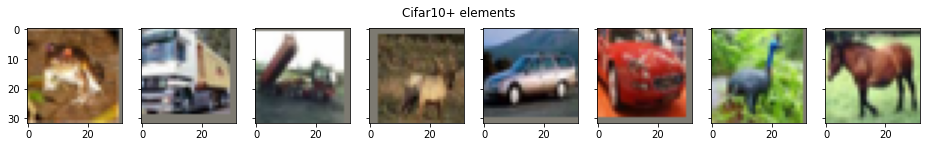

In [ ]:
#@title Plot some images


fig, axes = plt.subplots(1, 8, sharex=True, sharey=True, squeeze=True, figsize=(16, 2))
for i in range(8):
  mean = np.array([0.4914, 0.4822, 0.4465])
  std = np.array([0.2023, 0.1994, 0.2010])
  image, label = cifar_train[i]
  image_example = image.numpy().transpose((1, 2, 0))
  image_example= std * image_example + mean
  image_example= np.clip(image_example, 0, 1) 
  axes[i].imshow(image_example)
fig.suptitle('Cifar10+ elements')
plt.show()

### Model

In [ ]:
#@title Train and Test CifarCNN
model = CifarCNN()

model = train_Cifar(model)

acc = test_Cifar(model)

print(f'Test Accuracy: {acc :.3f}')

Size of training dataset:  40000 
 
Size of valid dataset:  10000


  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 0 | train loss:  0.032
validation loss descreased to  295.770
epoch 0 | validation accuracy:  32.230 |  validation loss:  0.030


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 1 | train loss:  0.028
validation loss descreased to  272.205
epoch 1 | validation accuracy:  36.590 |  validation loss:  0.027


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 2 | train loss:  0.027
validation loss descreased to  256.656
epoch 2 | validation accuracy:  40.030 |  validation loss:  0.026


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 3 | train loss:  0.025
validation loss descreased to  243.561
epoch 3 | validation accuracy:  43.960 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 4 | train loss:  0.024
validation loss descreased to  236.244
epoch 4 | validation accuracy:  45.640 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 5 | train loss:  0.023
validation loss descreased to  231.064
epoch 5 | validation accuracy:  47.130 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 6 | train loss:  0.023
validation loss descreased to  225.413
epoch 6 | validation accuracy:  48.810 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 7 | train loss:  0.022
validation loss descreased to  224.616
epoch 7 | validation accuracy:  48.860 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 8 | train loss:  0.022
validation loss descreased to  218.720
epoch 8 | validation accuracy:  50.010 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 9 | train loss:  0.022
validation loss descreased to  214.952
epoch 9 | validation accuracy:  51.170 |  validation loss:  0.021


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 10 | train loss:  0.021
validation loss descreased to  212.396
epoch 10 | validation accuracy:  51.750 |  validation loss:  0.021


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 11 | train loss:  0.021
validation loss descreased to  207.935
epoch 11 | validation accuracy:  52.870 |  validation loss:  0.021


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 12 | train loss:  0.021
validation loss descreased to  203.648
epoch 12 | validation accuracy:  54.280 |  validation loss:  0.020


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 13 | train loss:  0.020
epoch 13 | validation accuracy:  54.290 |  validation loss:  0.020


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 14 | train loss:  0.020
validation loss descreased to  201.709
epoch 14 | validation accuracy:  54.730 |  validation loss:  0.020


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 15 | train loss:  0.020
validation loss descreased to  199.062
epoch 15 | validation accuracy:  55.510 |  validation loss:  0.020


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 16 | train loss:  0.019
validation loss descreased to  196.106
epoch 16 | validation accuracy:  55.530 |  validation loss:  0.020


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 17 | train loss:  0.019
validation loss descreased to  191.864
epoch 17 | validation accuracy:  56.770 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 18 | train loss:  0.019
epoch 18 | validation accuracy:  56.600 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 19 | train loss:  0.018
validation loss descreased to  189.707
epoch 19 | validation accuracy:  57.320 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 20 | train loss:  0.018
validation loss descreased to  186.405
epoch 20 | validation accuracy:  58.080 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 21 | train loss:  0.018
validation loss descreased to  186.084
epoch 21 | validation accuracy:  58.290 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 22 | train loss:  0.018
validation loss descreased to  182.689
epoch 22 | validation accuracy:  58.960 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 23 | train loss:  0.017
epoch 23 | validation accuracy:  59.030 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 24 | train loss:  0.017
validation loss descreased to  182.330
epoch 24 | validation accuracy:  59.140 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 25 | train loss:  0.017
epoch 25 | validation accuracy:  57.980 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 26 | train loss:  0.017
validation loss descreased to  177.930
epoch 26 | validation accuracy:  59.900 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 27 | train loss:  0.017
epoch 27 | validation accuracy:  59.550 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 28 | train loss:  0.016
validation loss descreased to  175.723
epoch 28 | validation accuracy:  60.930 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 29 | train loss:  0.016
epoch 29 | validation accuracy:  60.590 |  validation loss:  0.018


 Test :   0%|          | 0/157 [00:00<?, ?it/s]


 Accuracy for class: plane is 65.4 %

 Accuracy for class: car   is 73.7 %

 Accuracy for class: bird  is 57.1 %

 Accuracy for class: cat   is 41.5 %

 Accuracy for class: deer  is 40.3 %

 Accuracy for class: dog   is 59.0 %

 Accuracy for class: frog  is 70.6 %

 Accuracy for class: horse is 59.4 %

 Accuracy for class: ship  is 70.1 %

 Accuracy for class: truck is 63.4 %
Test Accuracy: 60.050


In [ ]:
#@title CifarZ2CNN model

model = CifarZ2CNN()

model = train_Cifar(model)

acc = test_Cifar(model)

print(f'Test Accuracy: {acc :.3f}')

Size of training dataset:  40000 
 
Size of valid dataset:  10000


  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 0 | train loss:  0.030
validation loss descreased to  263.963
epoch 0 | validation accuracy:  39.540 |  validation loss:  0.026


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 1 | train loss:  0.024
validation loss descreased to  230.159
epoch 1 | validation accuracy:  48.100 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 2 | train loss:  0.022
validation loss descreased to  216.223
epoch 2 | validation accuracy:  51.050 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 3 | train loss:  0.021
validation loss descreased to  205.629
epoch 3 | validation accuracy:  53.950 |  validation loss:  0.021


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 4 | train loss:  0.019
validation loss descreased to  198.637
epoch 4 | validation accuracy:  55.920 |  validation loss:  0.020


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 5 | train loss:  0.019
validation loss descreased to  195.744
epoch 5 | validation accuracy:  56.240 |  validation loss:  0.020


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 6 | train loss:  0.018
validation loss descreased to  189.094
epoch 6 | validation accuracy:  58.010 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 7 | train loss:  0.017
validation loss descreased to  184.852
epoch 7 | validation accuracy:  58.630 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 8 | train loss:  0.017
validation loss descreased to  179.188
epoch 8 | validation accuracy:  60.650 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 9 | train loss:  0.016
validation loss descreased to  176.238
epoch 9 | validation accuracy:  61.330 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 10 | train loss:  0.016
validation loss descreased to  171.778
epoch 10 | validation accuracy:  62.620 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 11 | train loss:  0.015
validation loss descreased to  170.373
epoch 11 | validation accuracy:  62.750 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 12 | train loss:  0.015
validation loss descreased to  166.578
epoch 12 | validation accuracy:  63.690 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 13 | train loss:  0.014
validation loss descreased to  165.924
epoch 13 | validation accuracy:  63.880 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 14 | train loss:  0.014
epoch 14 | validation accuracy:  63.670 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 15 | train loss:  0.014
validation loss descreased to  162.717
epoch 15 | validation accuracy:  64.560 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 16 | train loss:  0.013
validation loss descreased to  162.703
epoch 16 | validation accuracy:  65.040 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 17 | train loss:  0.013
validation loss descreased to  158.873
epoch 17 | validation accuracy:  65.480 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 18 | train loss:  0.012
epoch 18 | validation accuracy:  65.230 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 19 | train loss:  0.012
epoch 19 | validation accuracy:  64.600 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 20 | train loss:  0.012
epoch 20 | validation accuracy:  65.720 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 21 | train loss:  0.011
epoch 21 | validation accuracy:  65.560 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 22 | train loss:  0.011
epoch 22 | validation accuracy:  65.950 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 23 | train loss:  0.011
epoch 23 | validation accuracy:  66.340 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 24 | train loss:  0.010
epoch 24 | validation accuracy:  65.890 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 25 | train loss:  0.010
epoch 25 | validation accuracy:  66.130 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 26 | train loss:  0.010
epoch 26 | validation accuracy:  65.470 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 27 | train loss:  0.010
epoch 27 | validation accuracy:  64.770 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 28 | train loss:  0.009
epoch 28 | validation accuracy:  65.240 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 29 | train loss:  0.009
epoch 29 | validation accuracy:  65.700 |  validation loss:  0.017


 Test :   0%|          | 0/157 [00:00<?, ?it/s]


 Accuracy for class: plane is 67.9 %

 Accuracy for class: car   is 79.6 %

 Accuracy for class: bird  is 50.3 %

 Accuracy for class: cat   is 35.6 %

 Accuracy for class: deer  is 61.3 %

 Accuracy for class: dog   is 72.0 %

 Accuracy for class: frog  is 71.1 %

 Accuracy for class: horse is 58.9 %

 Accuracy for class: ship  is 74.4 %

 Accuracy for class: truck is 77.7 %
Test Accuracy: 64.880


In [ ]:
#@title CifarP4CNN model

model = CifarP4CNN()

model = train_Cifar(model)

acc = test_Cifar(model)

print(f'Test Accuracy: {acc :.3f}')

# prima 65%

Size of training dataset:  40000 
 
Size of valid dataset:  10000


  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 0 | train loss:  0.031
validation loss descreased to  286.834
epoch 0 | validation accuracy:  34.370 |  validation loss:  0.029


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 1 | train loss:  0.026
validation loss descreased to  243.567
epoch 1 | validation accuracy:  43.330 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 2 | train loss:  0.023
validation loss descreased to  235.628
epoch 2 | validation accuracy:  45.200 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 3 | train loss:  0.022
validation loss descreased to  222.178
epoch 3 | validation accuracy:  48.540 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 4 | train loss:  0.021
validation loss descreased to  220.121
epoch 4 | validation accuracy:  49.260 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 5 | train loss:  0.021
validation loss descreased to  209.885
epoch 5 | validation accuracy:  51.900 |  validation loss:  0.021


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 6 | train loss:  0.020
validation loss descreased to  206.126
epoch 6 | validation accuracy:  53.080 |  validation loss:  0.021


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 7 | train loss:  0.019
validation loss descreased to  200.495
epoch 7 | validation accuracy:  54.710 |  validation loss:  0.020


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 8 | train loss:  0.019
validation loss descreased to  198.991
epoch 8 | validation accuracy:  54.910 |  validation loss:  0.020


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 9 | train loss:  0.018
validation loss descreased to  191.323
epoch 9 | validation accuracy:  56.710 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 10 | train loss:  0.018
epoch 10 | validation accuracy:  56.140 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 11 | train loss:  0.017
validation loss descreased to  187.830
epoch 11 | validation accuracy:  57.740 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 12 | train loss:  0.017
validation loss descreased to  185.926
epoch 12 | validation accuracy:  58.140 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 13 | train loss:  0.017
validation loss descreased to  178.288
epoch 13 | validation accuracy:  60.470 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 14 | train loss:  0.016
validation loss descreased to  178.060
epoch 14 | validation accuracy:  60.330 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 15 | train loss:  0.016
validation loss descreased to  174.970
epoch 15 | validation accuracy:  60.750 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 16 | train loss:  0.015
epoch 16 | validation accuracy:  60.240 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 17 | train loss:  0.015
epoch 17 | validation accuracy:  60.780 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 18 | train loss:  0.015
validation loss descreased to  172.358
epoch 18 | validation accuracy:  61.990 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 19 | train loss:  0.015
validation loss descreased to  169.789
epoch 19 | validation accuracy:  62.350 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 20 | train loss:  0.014
epoch 20 | validation accuracy:  62.370 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 21 | train loss:  0.014
epoch 21 | validation accuracy:  61.880 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 22 | train loss:  0.014
validation loss descreased to  168.041
epoch 22 | validation accuracy:  63.110 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 23 | train loss:  0.013
validation loss descreased to  166.526
epoch 23 | validation accuracy:  63.880 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 24 | train loss:  0.013
epoch 24 | validation accuracy:  63.450 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 25 | train loss:  0.013
validation loss descreased to  162.456
epoch 25 | validation accuracy:  64.820 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 26 | train loss:  0.013
epoch 26 | validation accuracy:  64.600 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 27 | train loss:  0.012
epoch 27 | validation accuracy:  64.090 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 28 | train loss:  0.012
epoch 28 | validation accuracy:  63.590 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 29 | train loss:  0.012
epoch 29 | validation accuracy:  64.660 |  validation loss:  0.017


 Test :   0%|          | 0/157 [00:00<?, ?it/s]


 Accuracy for class: plane is 69.4 %

 Accuracy for class: car   is 74.4 %

 Accuracy for class: bird  is 46.4 %

 Accuracy for class: cat   is 57.0 %

 Accuracy for class: deer  is 51.8 %

 Accuracy for class: dog   is 49.5 %

 Accuracy for class: frog  is 70.3 %

 Accuracy for class: horse is 72.7 %

 Accuracy for class: ship  is 68.3 %

 Accuracy for class: truck is 76.9 %
Test Accuracy: 63.670


In [ ]:
#@title CifarP4CNNWithBatchNorm model


model = CifarP4CNNWithBatchNorm()

model = train_Cifar(model)

acc = test_Cifar(model)

print(f'Test Accuracy: {acc :.3f}')


#prima 63%

Size of training dataset:  40000 
 
Size of valid dataset:  10000


  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 0 | train loss:  0.029
validation loss descreased to  250.934
epoch 0 | validation accuracy:  43.080 |  validation loss:  0.025


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 1 | train loss:  0.023
validation loss descreased to  218.745
epoch 1 | validation accuracy:  49.920 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 2 | train loss:  0.021
validation loss descreased to  210.069
epoch 2 | validation accuracy:  52.280 |  validation loss:  0.021


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 3 | train loss:  0.020
validation loss descreased to  197.128
epoch 3 | validation accuracy:  55.110 |  validation loss:  0.020


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 4 | train loss:  0.019
validation loss descreased to  189.264
epoch 4 | validation accuracy:  57.720 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 5 | train loss:  0.018
epoch 5 | validation accuracy:  56.950 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 6 | train loss:  0.017
validation loss descreased to  180.881
epoch 6 | validation accuracy:  59.440 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 7 | train loss:  0.016
validation loss descreased to  178.920
epoch 7 | validation accuracy:  60.000 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 8 | train loss:  0.016
validation loss descreased to  175.037
epoch 8 | validation accuracy:  61.370 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 9 | train loss:  0.015
validation loss descreased to  172.792
epoch 9 | validation accuracy:  61.850 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 10 | train loss:  0.015
validation loss descreased to  171.149
epoch 10 | validation accuracy:  62.160 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 11 | train loss:  0.014
validation loss descreased to  171.071
epoch 11 | validation accuracy:  62.330 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 12 | train loss:  0.014
epoch 12 | validation accuracy:  62.500 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 13 | train loss:  0.013
epoch 13 | validation accuracy:  62.310 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 14 | train loss:  0.013
validation loss descreased to  169.490
epoch 14 | validation accuracy:  63.120 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 15 | train loss:  0.012
validation loss descreased to  164.832
epoch 15 | validation accuracy:  64.090 |  validation loss:  0.016


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 16 | train loss:  0.012
epoch 16 | validation accuracy:  62.330 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 17 | train loss:  0.012
epoch 17 | validation accuracy:  63.970 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 18 | train loss:  0.011
epoch 18 | validation accuracy:  64.370 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 19 | train loss:  0.011
epoch 19 | validation accuracy:  64.380 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 20 | train loss:  0.011
epoch 20 | validation accuracy:  63.790 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 21 | train loss:  0.010
epoch 21 | validation accuracy:  64.830 |  validation loss:  0.017


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 22 | train loss:  0.010
epoch 22 | validation accuracy:  64.410 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 23 | train loss:  0.009
epoch 23 | validation accuracy:  64.200 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 24 | train loss:  0.009
epoch 24 | validation accuracy:  64.020 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 25 | train loss:  0.009
epoch 25 | validation accuracy:  64.220 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 26 | train loss:  0.008
epoch 26 | validation accuracy:  63.900 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 27 | train loss:  0.008
epoch 27 | validation accuracy:  64.400 |  validation loss:  0.018


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 28 | train loss:  0.008
epoch 28 | validation accuracy:  64.240 |  validation loss:  0.019


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 29 | train loss:  0.008
epoch 29 | validation accuracy:  63.750 |  validation loss:  0.019


 Test :   0%|          | 0/157 [00:00<?, ?it/s]


 Accuracy for class: plane is 69.2 %

 Accuracy for class: car   is 71.6 %

 Accuracy for class: bird  is 47.5 %

 Accuracy for class: cat   is 38.5 %

 Accuracy for class: deer  is 54.4 %

 Accuracy for class: dog   is 70.9 %

 Accuracy for class: frog  is 74.7 %

 Accuracy for class: horse is 65.8 %

 Accuracy for class: ship  is 73.3 %

 Accuracy for class: truck is 76.4 %
Test Accuracy: 64.230


## Cifar with rotation 
In this last case, we are implementing both translations and rotations on the CIFAR10 dataset, which is why we expect worse results in terms of accuracy compared to all other cases. The train and test split is done as previously

In [ ]:
#@title definition of dataset

transform_rot = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010]),
      transforms.RandomHorizontalFlip(p=0.5),
     # degrees : in range [-degrees,+degrees]
      transforms.RandomAffine(degrees=180, translate=(0.1,0.1)) 
    ])
            

cifar_train = torchvision.datasets.CIFAR10(
        "../data",
        train=True,
        download=True,
        transform=transform_rot)

cifar_test = torchvision.datasets.CIFAR10(
        "../data",
        train=False,
        download=True,
        transform=transform_rot)


output_classes = ('plane', 'car', 'bird', 'cat', 'deer', 
                  'dog', 'frog', 'horse', 'ship', 'truck')


#Check len
print("Len test", len(cifar_test))
print("Len train", len(cifar_train))


Files already downloaded and verified
Files already downloaded and verified
Len test 10000
Len train 50000


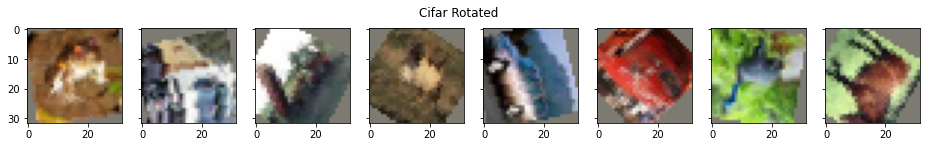

In [ ]:
#@title Plot some images 

fig, axes = plt.subplots(1, 8, sharex=True, sharey=True, squeeze=True, figsize=(16, 2))
for i in range(8):
  mean = np.array([0.4914, 0.4822, 0.4465])
  std = np.array([0.2023, 0.1994, 0.2010])
  image, label = cifar_train[i]
  image_example = image.numpy().transpose((1, 2, 0))
  image_example= std * image_example + mean
  image_example= np.clip(image_example, 0, 1) 
  axes[i].imshow(image_example)
fig.suptitle('Cifar Rotated')
plt.show()

### Model

In [ ]:
#@title Train and Test CifarCNN

model = CifarCNN()

model = train_Cifar(model)

acc = test_Cifar(model)

print(f'Test Accuracy: {acc :.3f}')

Size of training dataset:  40000 
 
Size of valid dataset:  10000


  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 0 | train loss:  0.033
validation loss descreased to  313.157
epoch 0 | validation accuracy:  26.600 |  validation loss:  0.031


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 1 | train loss:  0.030
validation loss descreased to  299.068
epoch 1 | validation accuracy:  29.640 |  validation loss:  0.030


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 2 | train loss:  0.029
validation loss descreased to  292.086
epoch 2 | validation accuracy:  32.270 |  validation loss:  0.029


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 3 | train loss:  0.029
validation loss descreased to  287.796
epoch 3 | validation accuracy:  33.250 |  validation loss:  0.029


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 4 | train loss:  0.029
epoch 4 | validation accuracy:  32.530 |  validation loss:  0.029


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 5 | train loss:  0.028
validation loss descreased to  281.345
epoch 5 | validation accuracy:  34.740 |  validation loss:  0.028


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 6 | train loss:  0.028
validation loss descreased to  279.859
epoch 6 | validation accuracy:  34.860 |  validation loss:  0.028


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 7 | train loss:  0.028
validation loss descreased to  276.135
epoch 7 | validation accuracy:  35.980 |  validation loss:  0.028


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 8 | train loss:  0.027
validation loss descreased to  273.798
epoch 8 | validation accuracy:  36.630 |  validation loss:  0.027


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 9 | train loss:  0.027
validation loss descreased to  272.262
epoch 9 | validation accuracy:  36.930 |  validation loss:  0.027


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 10 | train loss:  0.027
validation loss descreased to  270.574
epoch 10 | validation accuracy:  36.900 |  validation loss:  0.027


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 11 | train loss:  0.027
validation loss descreased to  268.886
epoch 11 | validation accuracy:  37.680 |  validation loss:  0.027


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 12 | train loss:  0.026
validation loss descreased to  267.165
epoch 12 | validation accuracy:  38.250 |  validation loss:  0.027


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 13 | train loss:  0.026
epoch 13 | validation accuracy:  38.020 |  validation loss:  0.027


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 14 | train loss:  0.026
validation loss descreased to  265.651
epoch 14 | validation accuracy:  38.590 |  validation loss:  0.027


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 15 | train loss:  0.026
validation loss descreased to  263.651
epoch 15 | validation accuracy:  38.700 |  validation loss:  0.026


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 16 | train loss:  0.026
epoch 16 | validation accuracy:  38.530 |  validation loss:  0.026


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 17 | train loss:  0.026
validation loss descreased to  261.462
epoch 17 | validation accuracy:  39.130 |  validation loss:  0.026


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 18 | train loss:  0.026
validation loss descreased to  260.098
epoch 18 | validation accuracy:  40.000 |  validation loss:  0.026


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 19 | train loss:  0.025
epoch 19 | validation accuracy:  39.530 |  validation loss:  0.026


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 20 | train loss:  0.025
epoch 20 | validation accuracy:  39.520 |  validation loss:  0.026


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 21 | train loss:  0.025
validation loss descreased to  256.182
epoch 21 | validation accuracy:  40.790 |  validation loss:  0.026


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 22 | train loss:  0.025
validation loss descreased to  255.780
epoch 22 | validation accuracy:  41.150 |  validation loss:  0.026


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 23 | train loss:  0.025
validation loss descreased to  253.417
epoch 23 | validation accuracy:  41.500 |  validation loss:  0.025


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 24 | train loss:  0.025
epoch 24 | validation accuracy:  41.810 |  validation loss:  0.025


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 25 | train loss:  0.025
validation loss descreased to  251.659
epoch 25 | validation accuracy:  41.920 |  validation loss:  0.025


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 26 | train loss:  0.025
epoch 26 | validation accuracy:  41.680 |  validation loss:  0.025


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 27 | train loss:  0.024
validation loss descreased to  250.290
epoch 27 | validation accuracy:  42.410 |  validation loss:  0.025


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 28 | train loss:  0.024
validation loss descreased to  249.627
epoch 28 | validation accuracy:  42.100 |  validation loss:  0.025


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 29 | train loss:  0.024
epoch 29 | validation accuracy:  42.330 |  validation loss:  0.025


 Test :   0%|          | 0/157 [00:00<?, ?it/s]


 Accuracy for class: plane is 51.5 %

 Accuracy for class: car   is 45.6 %

 Accuracy for class: bird  is 22.6 %

 Accuracy for class: cat   is 29.3 %

 Accuracy for class: deer  is 37.2 %

 Accuracy for class: dog   is 38.7 %

 Accuracy for class: frog  is 68.2 %

 Accuracy for class: horse is 41.3 %

 Accuracy for class: ship  is 47.7 %

 Accuracy for class: truck is 48.5 %
Test Accuracy: 43.060


In [ ]:
#@title CifarZ2CNN model

model = CifarZ2CNN()

model = train_Cifar(model)

acc = test_Cifar(model)

print(f'Test Accuracy: {acc :.3f}')


Size of training dataset:  40000 
 
Size of valid dataset:  10000


  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 0 | train loss:  0.032
validation loss descreased to  290.120
epoch 0 | validation accuracy:  33.610 |  validation loss:  0.029


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 1 | train loss:  0.028
validation loss descreased to  274.590
epoch 1 | validation accuracy:  35.800 |  validation loss:  0.027


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 2 | train loss:  0.027
validation loss descreased to  264.313
epoch 2 | validation accuracy:  39.090 |  validation loss:  0.026


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 3 | train loss:  0.026
validation loss descreased to  262.492
epoch 3 | validation accuracy:  39.530 |  validation loss:  0.026


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 4 | train loss:  0.025
validation loss descreased to  255.367
epoch 4 | validation accuracy:  41.200 |  validation loss:  0.026


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 5 | train loss:  0.025
epoch 5 | validation accuracy:  40.990 |  validation loss:  0.026


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 6 | train loss:  0.024
validation loss descreased to  251.877
epoch 6 | validation accuracy:  42.260 |  validation loss:  0.025


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 7 | train loss:  0.024
validation loss descreased to  250.180
epoch 7 | validation accuracy:  42.670 |  validation loss:  0.025


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 8 | train loss:  0.024
validation loss descreased to  245.649
epoch 8 | validation accuracy:  43.400 |  validation loss:  0.025


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 9 | train loss:  0.023
validation loss descreased to  243.380
epoch 9 | validation accuracy:  44.240 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 10 | train loss:  0.023
validation loss descreased to  242.568
epoch 10 | validation accuracy:  43.830 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 11 | train loss:  0.023
validation loss descreased to  242.403
epoch 11 | validation accuracy:  44.030 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 12 | train loss:  0.022
validation loss descreased to  240.152
epoch 12 | validation accuracy:  44.780 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 13 | train loss:  0.022
epoch 13 | validation accuracy:  44.160 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 14 | train loss:  0.022
epoch 14 | validation accuracy:  45.160 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 15 | train loss:  0.021
validation loss descreased to  236.921
epoch 15 | validation accuracy:  45.850 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 16 | train loss:  0.021
epoch 16 | validation accuracy:  45.720 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 17 | train loss:  0.021
epoch 17 | validation accuracy:  45.650 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 18 | train loss:  0.020
validation loss descreased to  234.507
epoch 18 | validation accuracy:  46.470 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 19 | train loss:  0.020
epoch 19 | validation accuracy:  46.310 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 20 | train loss:  0.019
epoch 20 | validation accuracy:  46.330 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 21 | train loss:  0.019
epoch 21 | validation accuracy:  46.030 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 22 | train loss:  0.019
epoch 22 | validation accuracy:  46.990 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 23 | train loss:  0.018
epoch 23 | validation accuracy:  46.370 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 24 | train loss:  0.018
epoch 24 | validation accuracy:  45.720 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 25 | train loss:  0.018
epoch 25 | validation accuracy:  46.090 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 26 | train loss:  0.017
epoch 26 | validation accuracy:  46.560 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 27 | train loss:  0.017
epoch 27 | validation accuracy:  45.420 |  validation loss:  0.025


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 28 | train loss:  0.017
epoch 28 | validation accuracy:  46.480 |  validation loss:  0.025


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 29 | train loss:  0.016
epoch 29 | validation accuracy:  45.780 |  validation loss:  0.025


 Test :   0%|          | 0/157 [00:00<?, ?it/s]


 Accuracy for class: plane is 48.7 %

 Accuracy for class: car   is 45.3 %

 Accuracy for class: bird  is 25.4 %

 Accuracy for class: cat   is 31.2 %

 Accuracy for class: deer  is 45.6 %

 Accuracy for class: dog   is 52.1 %

 Accuracy for class: frog  is 59.7 %

 Accuracy for class: horse is 45.8 %

 Accuracy for class: ship  is 55.3 %

 Accuracy for class: truck is 56.1 %
Test Accuracy: 46.520


In [ ]:
#@title CifarP4CNN model

model = CifarP4CNN()

model = train_Cifar(model)

acc = test_Cifar(model)

print(f'Test Accuracy: {acc :.3f}')

Size of training dataset:  40000 
 
Size of valid dataset:  10000


  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 0 | train loss:  0.032
validation loss descreased to  303.341
epoch 0 | validation accuracy:  29.740 |  validation loss:  0.030


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 1 | train loss:  0.029
validation loss descreased to  281.987
epoch 1 | validation accuracy:  36.010 |  validation loss:  0.028


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 2 | train loss:  0.028
validation loss descreased to  272.785
epoch 2 | validation accuracy:  37.250 |  validation loss:  0.027


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 3 | train loss:  0.027
validation loss descreased to  262.596
epoch 3 | validation accuracy:  40.070 |  validation loss:  0.026


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 4 | train loss:  0.026
epoch 4 | validation accuracy:  37.810 |  validation loss:  0.027


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 5 | train loss:  0.025
validation loss descreased to  251.701
epoch 5 | validation accuracy:  42.520 |  validation loss:  0.025


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 6 | train loss:  0.025
validation loss descreased to  249.836
epoch 6 | validation accuracy:  43.280 |  validation loss:  0.025


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 7 | train loss:  0.024
validation loss descreased to  246.708
epoch 7 | validation accuracy:  44.030 |  validation loss:  0.025


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 8 | train loss:  0.024
validation loss descreased to  242.928
epoch 8 | validation accuracy:  45.060 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 9 | train loss:  0.023
validation loss descreased to  241.631
epoch 9 | validation accuracy:  45.670 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 10 | train loss:  0.023
validation loss descreased to  234.925
epoch 10 | validation accuracy:  46.850 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 11 | train loss:  0.022
validation loss descreased to  231.387
epoch 11 | validation accuracy:  47.270 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 12 | train loss:  0.022
epoch 12 | validation accuracy:  47.510 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 13 | train loss:  0.022
epoch 13 | validation accuracy:  47.560 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 14 | train loss:  0.021
validation loss descreased to  227.228
epoch 14 | validation accuracy:  48.930 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 15 | train loss:  0.021
validation loss descreased to  224.881
epoch 15 | validation accuracy:  49.260 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 16 | train loss:  0.021
epoch 16 | validation accuracy:  49.140 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 17 | train loss:  0.020
epoch 17 | validation accuracy:  49.480 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 18 | train loss:  0.020
epoch 18 | validation accuracy:  47.730 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 19 | train loss:  0.020
validation loss descreased to  223.026
epoch 19 | validation accuracy:  50.110 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 20 | train loss:  0.020
epoch 20 | validation accuracy:  48.560 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 21 | train loss:  0.019
validation loss descreased to  221.234
epoch 21 | validation accuracy:  50.230 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 22 | train loss:  0.019
epoch 22 | validation accuracy:  49.940 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 23 | train loss:  0.019
validation loss descreased to  218.080
epoch 23 | validation accuracy:  50.690 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 24 | train loss:  0.019
epoch 24 | validation accuracy:  50.490 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 25 | train loss:  0.018
epoch 25 | validation accuracy:  50.780 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 26 | train loss:  0.018
epoch 26 | validation accuracy:  51.180 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 27 | train loss:  0.018
epoch 27 | validation accuracy:  51.060 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 28 | train loss:  0.018
epoch 28 | validation accuracy:  51.120 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 29 | train loss:  0.017
epoch 29 | validation accuracy:  51.240 |  validation loss:  0.022


 Test :   0%|          | 0/157 [00:00<?, ?it/s]


 Accuracy for class: plane is 54.6 %

 Accuracy for class: car   is 61.2 %

 Accuracy for class: bird  is 35.7 %

 Accuracy for class: cat   is 32.2 %

 Accuracy for class: deer  is 49.4 %

 Accuracy for class: dog   is 39.2 %

 Accuracy for class: frog  is 65.1 %

 Accuracy for class: horse is 56.3 %

 Accuracy for class: ship  is 63.2 %

 Accuracy for class: truck is 55.3 %
Test Accuracy: 51.220


In [ ]:
#@title CifarP4CNNWithBatchNorm model

model = CifarP4CNNWithBatchNorm()

model = train_Cifar(model)

acc = test_Cifar(model)

print(f'Test Accuracy: {acc :.3f}')

Size of training dataset:  40000 
 
Size of valid dataset:  10000


  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 0 | train loss:  0.030
validation loss descreased to  283.724
epoch 0 | validation accuracy:  33.450 |  validation loss:  0.028


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 1 | train loss:  0.027
validation loss descreased to  264.441
epoch 1 | validation accuracy:  39.750 |  validation loss:  0.026


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 2 | train loss:  0.026
validation loss descreased to  260.099
epoch 2 | validation accuracy:  40.990 |  validation loss:  0.026


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 3 | train loss:  0.025
validation loss descreased to  252.434
epoch 3 | validation accuracy:  41.970 |  validation loss:  0.025


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 4 | train loss:  0.024
validation loss descreased to  242.792
epoch 4 | validation accuracy:  44.410 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 5 | train loss:  0.023
epoch 5 | validation accuracy:  44.460 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 6 | train loss:  0.022
validation loss descreased to  237.196
epoch 6 | validation accuracy:  45.930 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 7 | train loss:  0.022
validation loss descreased to  234.048
epoch 7 | validation accuracy:  46.420 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 8 | train loss:  0.021
validation loss descreased to  229.898
epoch 8 | validation accuracy:  47.370 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 9 | train loss:  0.021
validation loss descreased to  227.393
epoch 9 | validation accuracy:  48.110 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 10 | train loss:  0.020
validation loss descreased to  226.615
epoch 10 | validation accuracy:  48.400 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 11 | train loss:  0.020
epoch 11 | validation accuracy:  47.850 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 12 | train loss:  0.020
epoch 12 | validation accuracy:  48.370 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 13 | train loss:  0.019
epoch 13 | validation accuracy:  47.730 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 14 | train loss:  0.019
epoch 14 | validation accuracy:  48.240 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 15 | train loss:  0.018
validation loss descreased to  222.926
epoch 15 | validation accuracy:  49.900 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 16 | train loss:  0.018
epoch 16 | validation accuracy:  50.170 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 17 | train loss:  0.018
epoch 17 | validation accuracy:  50.710 |  validation loss:  0.022


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 18 | train loss:  0.017
epoch 18 | validation accuracy:  49.700 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 19 | train loss:  0.017
epoch 19 | validation accuracy:  50.160 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 20 | train loss:  0.017
epoch 20 | validation accuracy:  49.990 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 21 | train loss:  0.016
epoch 21 | validation accuracy:  48.870 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 22 | train loss:  0.016
epoch 22 | validation accuracy:  50.700 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 23 | train loss:  0.016
epoch 23 | validation accuracy:  49.360 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 24 | train loss:  0.015
epoch 24 | validation accuracy:  50.010 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 25 | train loss:  0.015
epoch 25 | validation accuracy:  50.950 |  validation loss:  0.023


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 26 | train loss:  0.015
epoch 26 | validation accuracy:  49.540 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 27 | train loss:  0.014
epoch 27 | validation accuracy:  49.970 |  validation loss:  0.024


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 28 | train loss:  0.014
epoch 28 | validation accuracy:  49.540 |  validation loss:  0.025


Train:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 29 | train loss:  0.014
epoch 29 | validation accuracy:  49.660 |  validation loss:  0.025


 Test :   0%|          | 0/157 [00:00<?, ?it/s]


 Accuracy for class: plane is 50.9 %

 Accuracy for class: car   is 51.6 %

 Accuracy for class: bird  is 17.3 %

 Accuracy for class: cat   is 36.7 %

 Accuracy for class: deer  is 52.4 %

 Accuracy for class: dog   is 44.4 %

 Accuracy for class: frog  is 56.7 %

 Accuracy for class: horse is 51.3 %

 Accuracy for class: ship  is 63.9 %

 Accuracy for class: truck is 60.0 %
Test Accuracy: 48.520


# Task 3 secon part

This section is in another notebook because there is an issue with the current Python (3.9.16) version and some packages used in the libraries escnn and e2cnn (they accept below 3.8.10).